In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pertpy as pt
import scanpy as sc
import pandas as pd
import seaborn as sb

plt.rcParams["figure.figsize"] = (7, 7)
import numpy as np

sc.settings.verbosity = 3

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm, colors

#Define a nice colour map for gene expression
colors2 = plt.cm.plasma(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap2 = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [4]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)
library(ggrastr)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths



In [7]:
## Define color palette
pal = sb.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR':pal[7], 'AR':pal[9], 'joint_CR':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [8]:
import os,sys

figdir = './'
if not os.path.exists(figdir):
    os.mkdir(figdir)
sc.settings.figdir = figdir

In [9]:
%%R -i design_palette_df -i figdir
design_palette = setNames(design_palette_df$color, rownames(design_palette_df))

In [10]:
from adjustText import adjust_text
import matplotlib.patheffects as pe

def gen_mpl_labels(
    adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None
):
    if adjust_kwargs is None:
        adjust_kwargs = {"text_from_points": False}
    if text_kwargs is None:
        text_kwargs = {}

    medians = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        medians[g] = np.median(adata[g_idx].obsm["X_umap"], axis=0)

    if ax is None:
        texts = [
            plt.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()
        ]
    else:
        texts = [ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()]

    adjust_text(texts, **adjust_kwargs)

In [11]:
def plot_w_ggplot(r_fct_str, args, figdir='.', pl_name='plot', pl_width=8, pl_height=8):

    import rpy2.robjects.pandas2ri
    import rpy2.robjects.numpy2ri
    from rpy2.robjects.packages import STAP

    r_pkg = STAP(r_fct_str, "r_pkg")
    #this was needed for the code to run on jhub
    #if you have a different version of rpy2 you may not need these two lines
    rpy2.robjects.pandas2ri.activate()
    rpy2.robjects.numpy2ri.activate()
    
    # PASS OBJECTS INTO FUNCTION
    pl = r_pkg.plot_func(args)
    
    ggsave_str = '''
    save_plot <- function(pl, figdir, pl_name, pl_width, pl_height){
        pl + 
        ggsave(file.path(figdir, paste0(pl_name, ".png")), width=pl_width, height=pl_height)  +
        ggsave(file.path(figdir, paste0(pl_name, ".pdf")), width=pl_width, height=pl_height)
    }
    
    '''
    r_save = STAP(ggsave_str, "r_save")
    r_save.save_plot(pl, figdir, pl_name=pl_name, pl_width=pl_width, pl_height=pl_height)
    

# Set up anndata

In [12]:
adata = sc.read_h5ad('/scratch365/eaboelno/BACKUP_h5ad_IMPORTANT/adata_mm_MG_fine_type_WORKING.h5ad')
adata

AnnData object with n_obs × n_vars = 52981 × 19308
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'system_map', 'indiv_treatment_time', 'lesion_status', 'lesion_condition', 'S_score', 'G2M_score', 'Cycling cells', 'S phase', 'Cycling_cells', 'S_phase_cells', 'cluster_annotation', 'cell_leiden_annotated', 'common_innate_immunity_signature', 'IRAS1', 'IRAS2', 'leiden_MG_r0.5', 'leiden_MG_r0.7', 'leiden_MG_r1', 'leiden_MG_r0.3', 'minimal_treatment_map', 'MG_type_fine', 'MG_leiden_annotated', 'NEW_treatment_map', 'individual_lesion_condition', 'MG_type_broad', 'MG_type_fine_reduced', 'MG_type_fine_NEW', 'MG_type_fine_NEW_NUMBERED', 'MG_type_fine_NUMBERED', 'MG_type_fine_LETTER'
   

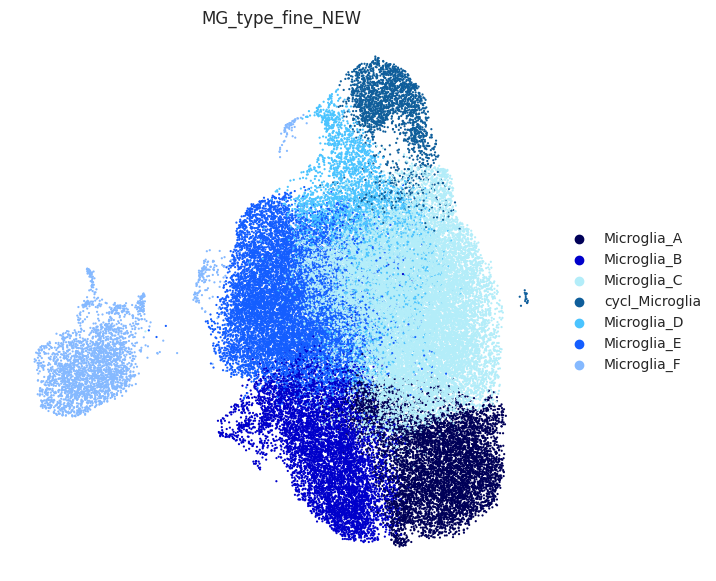

In [13]:
#Visualize the clustering and how this is reflected by different technical covariate
sc.pl.umap(adata, color=['MG_type_fine_NEW'], legend_fontsize =float(10) , wspace=0.6, 
           legend_fontweight= 'bold', frameon= False, s=10, 
           legend_fontoutline=1) #save=time+'_annotated_cell_types_NEW.pdf' )

In [14]:
# Unique values in the 'condition' column
unique_conditions = adata.obs['MG_type_fine_NEW'].unique()
for condition in unique_conditions:
    print(condition)

Microglia_E
cycl_Microglia
Microglia_C
Microglia_D
Microglia_F
Microglia_A
Microglia_B


In [15]:
# Unique values in the 'condition' column
unique_conditions = adata.obs['lesion_status'].unique()
for condition in unique_conditions:
    print(condition)

LPC_demyel
LPC_baseline
Cupr_demyel
Cupr_baseline
LPC_remyel
LPC_mid_remyel
Cupr_remyel


# Start MILO analysis--

In [16]:
## Initialize object for Milo analysis
milo = pt.tl.Milo()
mdata = milo.load(adata)
mdata

MuData object with n_obs × n_vars = 52981 × 19308
  2 modalities
    rna:	52981 x 19308
      obs:	'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'system_map', 'indiv_treatment_time', 'lesion_status', 'lesion_condition', 'S_score', 'G2M_score', 'Cycling cells', 'S phase', 'Cycling_cells', 'S_phase_cells', 'cluster_annotation', 'cell_leiden_annotated', 'common_innate_immunity_signature', 'IRAS1', 'IRAS2', 'leiden_MG_r0.5', 'leiden_MG_r0.7', 'leiden_MG_r1', 'leiden_MG_r0.3', 'minimal_treatment_map', 'MG_type_fine', 'MG_leiden_annotated', 'NEW_treatment_map', 'individual_lesion_condition', 'MG_type_broad', 'MG_type_fine_reduced', 'MG_type_fine_NEW', 'MG_type_fine_NEW_NUMBERED', 'MG_type_fine_NUMBERED', 'MG_type_fine_LETTER'
      var:	'hb', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
      uns:	'Cycling_cells_colors', 'MG_leiden_annotated_colors', 'MG_leiden_annotated_sizes', 'MG_type_fine_LETTER_colors', 'MG_type_fine_LETTER_sizes', 'MG_type_fine_NEW_NUMBERED_colors', 'MG_type_fine_NEW_colors', 'MG_type_fine_NEW_sizes', 'MG_type_fine_NUMBERED_colors', 'MG_type_fine_colors', 'MG_type_fine_reduced_colors', 'MG_type_fine_sizes', 'S_phase_cells_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_leiden_annotated_colors', 'cluster_annotation_colors', 'covariate_categ_orders', 'covariate_key_orders', 'dendrogram_MG_leiden_annotated', 'dendrogram_MG_type_fine', 'dendrogram_MG_type_fine_NEW', 'dendrogram_MG_type_fine_reduced', 'dendrogram_cell_type_eval', 'dendrogram_cluster_annotation', 'dendrogram_condition', 'dendrogram_leiden_MG_r0.3', 'dendrogram_leiden_MG_r0.5', 'dendrogram_lesion_condition', 'dendrogram_sys_leiden_1', 'hvg', 'layer_information', 'leiden', 'leiden_MG_r0.3', 'leiden_MG_r0.3_colors', 'leiden_MG_r0.3_sizes', 'leiden_MG_r0.5', 'leiden_MG_r0.5_colors', 'leiden_MG_r0.7', 'leiden_MG_r0.7_colors', 'leiden_MG_r1', 'leiden_MG_r1_colors', 'lesion_condition_colors', 'neighbors', 'paga', 'phase_colors', 'publication_colors', 'rank_genes_MG_type_fine_NEW', 'rank_genes_groups', 'rank_genes_leiden_MG_r0.3', 'rank_genes_leiden_MG_r0.5', 'rank_genes_reduced', 'sys_leiden_1_colors', 'sys_leiden_2_colors', 'sys_leiden_new_1_colors', 'sys_leiden_new_2_colors', 'system_order', 'type_fine_colors', 'umap'
      obsm:	'X_pca', 'X_sysVI', 'X_umap', 'covariates', 'system'
      layers:	'counts', 'log1p_norm', 'scaled'
      obsp:	'connectivities', 'distances'
    milo:	0 x 0

In [17]:
sc.pp.neighbors(mdata["rna"], use_rep="X_sysVI", n_neighbors=300)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:09:32)


In [18]:
milo.make_nhoods(mdata["rna"], prop=0.1)

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/pertpy/tools/_milo.py:186: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.185634  3.6756496 3.1463242 ... 1.8544719 2.0075374 2.502783 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs["nhood_ixs_refined"] == 1, "nhood_kth_distance"] = k_distances


In [19]:
mdata['rna'].obsm

AxisArrays with keys: X_pca, X_sysVI, X_umap, covariates, system, nhoods

In [20]:
mdata["rna"].obsm["nhoods"]

<52981x4251 sparse matrix of type '<class 'numpy.float32'>'
	with 2318862 stored elements in Compressed Sparse Row format>

In [21]:
mdata["rna"][mdata["rna"].obs["nhood_ixs_refined"] != 0].obs[["nhood_ixs_refined", "nhood_kth_distance"]]

nhood_ixs_refined  nhood_kth_distance
barcode                                                         
TGGATGTAGGTTAGTA-1_adams                   1            4.185634
CTGTGAACACTGTTCC-1_adams                   1            3.675650
TTCCTCTGTATGTCAC-1_adams                   1            3.146324
GTTAGACTCAACCTTT-1_adams                   1            2.151174
TACTTGTAGCGGGTTA-1_adams                   1            3.145792
...                                      ...                 ...
GAACGGAGTCATGCAT-1_shen                    1            2.327187
CATTCGCTCGTCTGCT-1-1_shen                  1            1.981771
CGATCGGAGGCTAGCA-1-2_shen                  1            1.854472
TTAGTTCTCTGAGGGA-1_shen                    1            2.007537
GAGCAGACAATAGCGG-1_shen                    1            2.502783

[4251 rows x 2 columns]

Text(0, 0.5, '# nhoods')

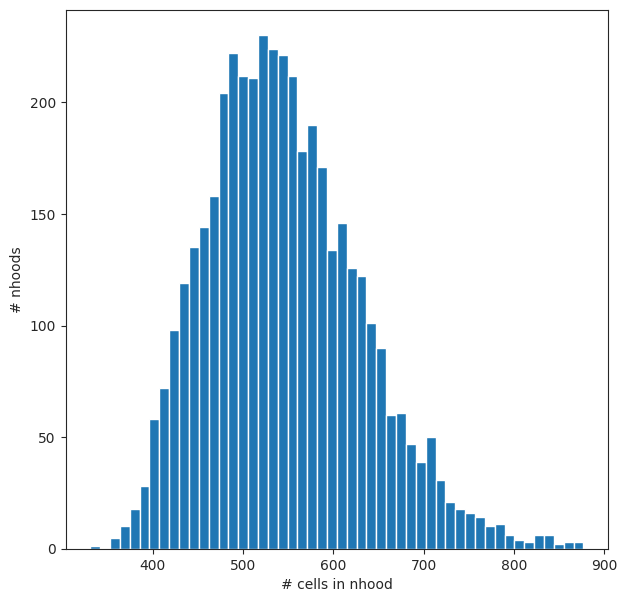

In [22]:
nhood_size = np.array(mdata["rna"].obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=50)
plt.xlabel("# cells in nhood")
plt.ylabel("# nhoods")

In [23]:
np.median(nhood_size)
#Want 5*number of samples 

537.0

In [24]:
mdata = milo.count_nhoods(mdata, sample_col="sample_id")

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [25]:
mdata["milo"]

AnnData object with n_obs × n_vars = 30 × 4251
    var: 'index_cell', 'kth_distance'
    uns: 'sample_col'

# Set up comparison

In [27]:
# Update the 'treatment_meta' column based on the mapping
mdata["rna"].obs['status'] = mdata["rna"].obs['lesion_status']

In [28]:
# Unique values in the 'condition' column
unique_conditions = mdata["rna"].obs["status"].unique()
for condition in unique_conditions:
    print(condition)

LPC_demyel
LPC_baseline
Cupr_demyel
Cupr_baseline
LPC_remyel
LPC_mid_remyel
Cupr_remyel


In [58]:
# Convert the 'status' column to categorical dtype first
mdata["rna"].obs["status"] = mdata["rna"].obs["status"].astype("category")

# Now reorder the categories as you were trying to do
mdata["rna"].obs["status"] = mdata["rna"].obs["status"].cat.reorder_categories([
    "LPC_baseline", "LPC_demyel", "LPC_mid_remyel", "LPC_remyel", "Cupr_baseline", "Cupr_demyel", "Cupr_remyel"], ordered=True)

In [29]:
milo.da_nhoods(
    mdata, design="~status", model_contrasts="statusLPC_demyel-statusLPC_baseline"
)

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/pertpy/tools/_milo.py:691: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalues = pvalues[keep_nhoods][o]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/pertpy/tools/_milo.py:692: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w = w[keep_nhoods][o]


In [30]:
mdata["milo"]

AnnData object with n_obs × n_vars = 30 × 4251
    obs: 'status', 'sample_id'
    var: 'index_cell', 'kth_distance', 'logFC', 'logCPM', 'F', 'PValue', 'FDR', 'SpatialFDR'
    uns: 'sample_col'

Text(0, 0.5, 'Mean # cells per sample in nhood')

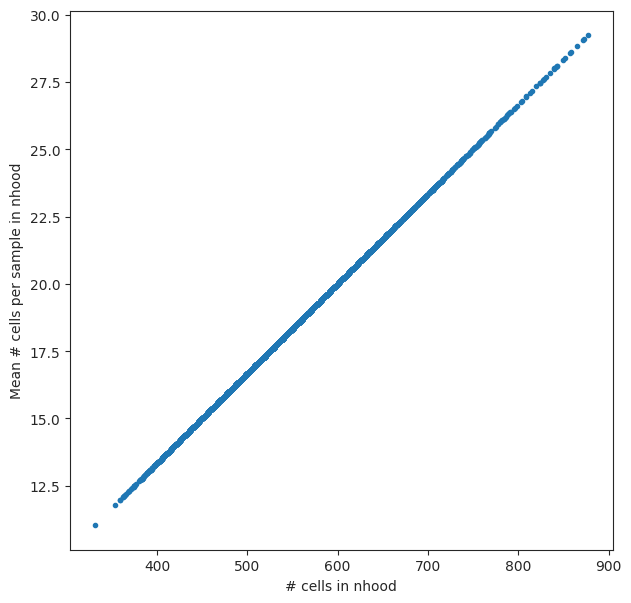

In [31]:
mean_n_cells = mdata["milo"].X.toarray().mean(0)
plt.plot(nhood_size, mean_n_cells, ".")
plt.xlabel("# cells in nhood")
plt.ylabel("Mean # cells per sample in nhood")

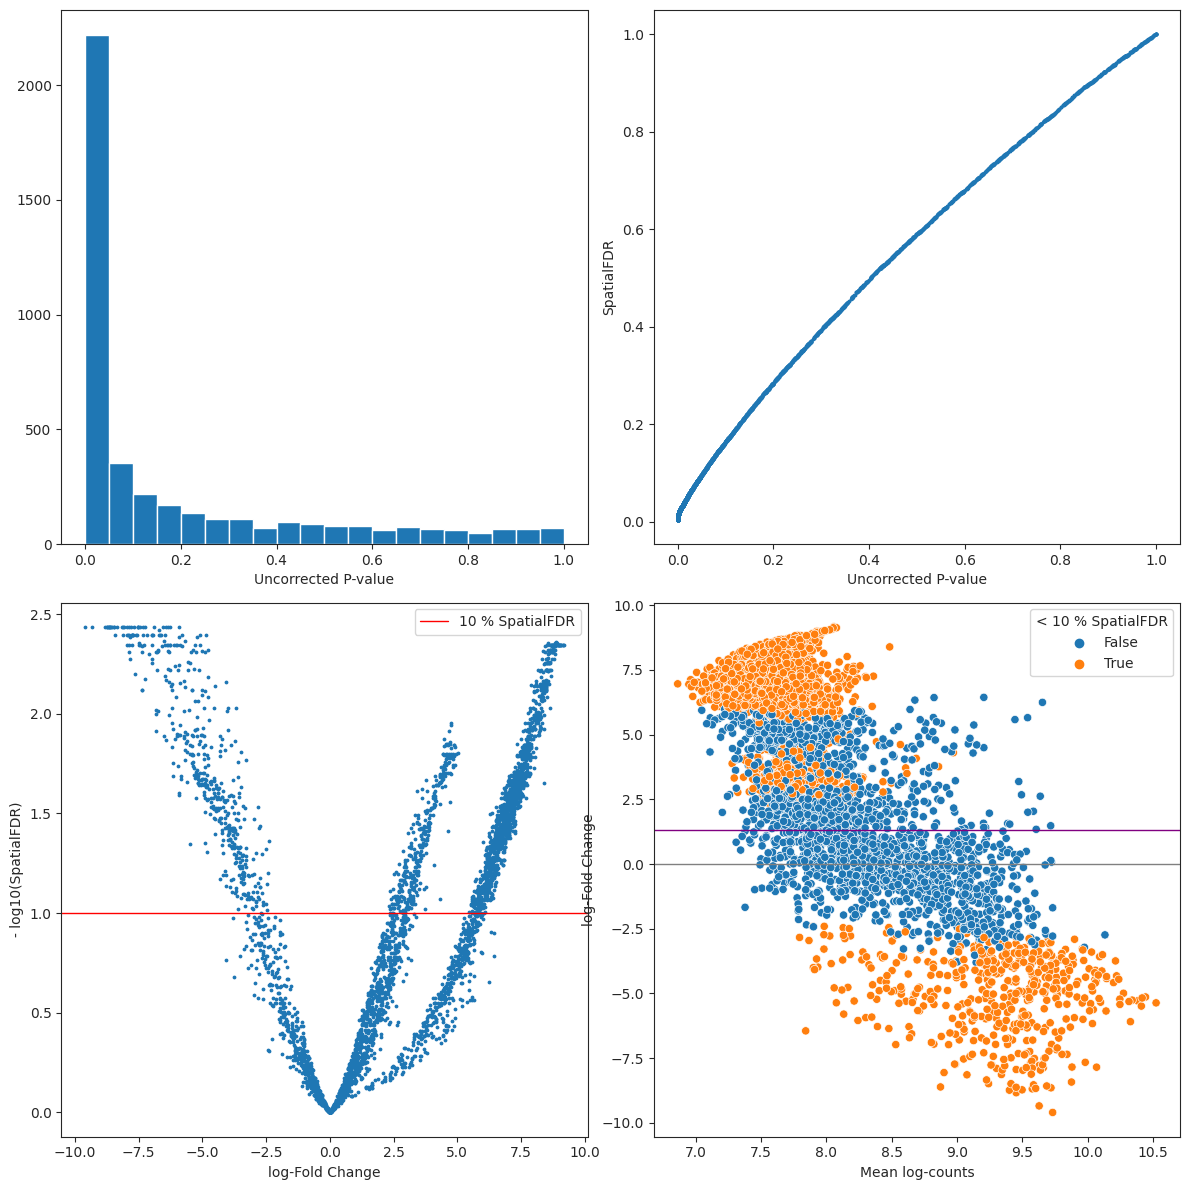

In [32]:
def plot_milo_diagnostics(mdata):
    alpha = 0.1  ## significance threshold

    with matplotlib.rc_context({"figure.figsize": [12, 12]}):

        ## Check P-value histogram
        plt.subplot(2, 2, 1)
        plt.hist(mdata["milo"].var["PValue"], bins=20)
        plt.xlabel("Uncorrected P-value")

        ## Visualize extent of multiple-testing correction
        plt.subplot(2, 2, 2)
        plt.scatter(
            mdata["milo"].var["PValue"],
            mdata["milo"].var["SpatialFDR"],
            s=3,
        )
        plt.xlabel("Uncorrected P-value")
        plt.ylabel("SpatialFDR")

        ## Visualize volcano plot
        plt.subplot(2, 2, 3)
        plt.scatter(
            mdata["milo"].var["logFC"],
            -np.log10(mdata["milo"].var["SpatialFDR"]),
            s=3,
        )
        plt.axhline(
            y=-np.log10(alpha),
            color="red",
            linewidth=1,
            label=f"{int(alpha*100)} % SpatialFDR",
        )
        plt.legend()
        plt.xlabel("log-Fold Change")
        plt.ylabel("- log10(SpatialFDR)")
        plt.tight_layout()

        ## Visualize MA plot
        df = mdata["milo"].var
        emp_null = df[df["SpatialFDR"] >= alpha]["logFC"].mean()
        df["Sig"] = df["SpatialFDR"] < alpha

        plt.subplot(2, 2, 4)
        sb.scatterplot(data=df, x="logCPM", y="logFC", hue="Sig")
        plt.axhline(y=0, color="grey", linewidth=1)
        plt.axhline(y=emp_null, color="purple", linewidth=1)
        plt.legend(title=f"< {int(alpha*100)} % SpatialFDR")
        plt.xlabel("Mean log-counts")
        plt.ylabel("log-Fold Change")
        plt.show()


plot_milo_diagnostics(mdata)

# Visualize results on embedding

In [33]:
milo.build_nhood_graph(mdata)

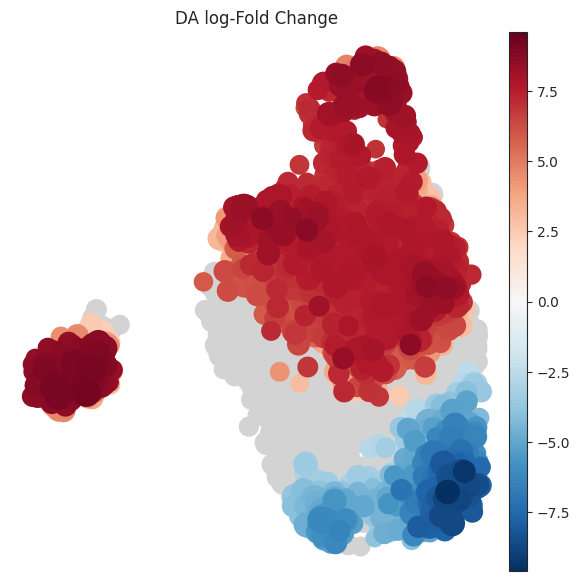

In [35]:
plt.rcParams["figure.figsize"] = [7, 7]
milo.plot_nhood_graph(
    mdata,
    alpha=0.1,  ## SpatialFDR level (0.1%)
    min_size=2,  ## Size of smallest dot
    plot_edges=False,
    #save='_LPC_demyelination_ALL.png'
)

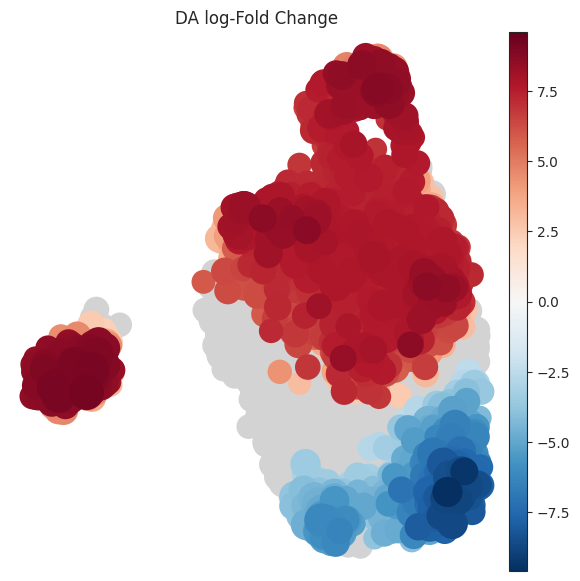

In [39]:
import os

# Ensure the subfolder exists
output_folder = "MG_figures"
os.makedirs(output_folder, exist_ok=True)

# Set the save directory and ensure it exists
output_folder = "./MG_figures"
os.makedirs(output_folder, exist_ok=True)

# Prepend the folder to the save filename
plt.rcParams["figure.figsize"] = [7, 7]
milo.plot_nhood_graph(
    mdata,
    alpha=0.1,  # SpatialFDR level (0.1%)
    min_size=3,  # Size of smallest dot
    plot_edges=False,
    save="_LPC_demyel_MG_all.png"
)

In [ ]:
import os

# Ensure the subfolder exists
output_folder = "MG_figures"
os.makedirs(output_folder, exist_ok=True)

# Set the save directory and ensure it exists
output_folder = "./MG_figures"
os.makedirs(output_folder, exist_ok=True)

# Prepend the folder to the save filename
plt.rcParams["figure.figsize"] = [7, 7]
milo.plot_nhood_graph(
    mdata,
    alpha=0.1,  # SpatialFDR level (0.1%)
    min_size=3,  # Size of smallest dot
    plot_edges=False,
    save="_LPC_demyel_MG_all.png"
)

# Visualize by cell type

In [40]:
milo.annotate_nhoods(mdata, anno_col="MG_type_fine_NEW")

Text(0.5, 0, 'celltype fraction')

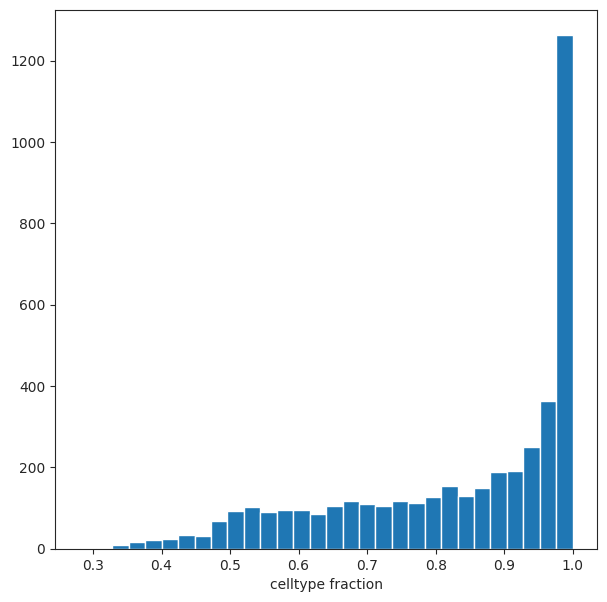

In [41]:
plt.hist(mdata["milo"].var["nhood_annotation_frac"], bins=30)
plt.xlabel("celltype fraction")

In [42]:
# Check current categories of 'nhood_annotation'
current_categories = mdata["milo"].var["nhood_annotation"].cat.categories

# Add new category 'Mixed' if it doesn't already exist
if "Mixed" not in current_categories:
    mdata["milo"].var["nhood_annotation"] = mdata["milo"].var["nhood_annotation"].cat.add_categories("Mixed")

# Now assign "Mixed" to rows where 'nhood_annotation_frac' < 0.6
mdata["milo"].var.loc[mdata["milo"].var["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/pertpy/tools/_milo.py:908: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nhood_adata.obs[[anno_col, "logFC"]].groupby(anno_col).median().sort_values("logFC", ascending=True).index
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is 

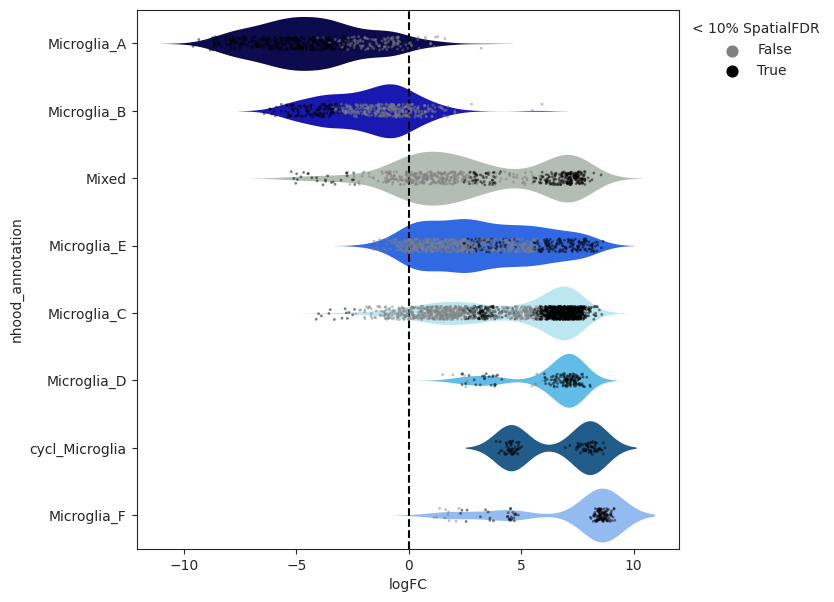

In [45]:
cluster_color = {     
    'cycl_Microglia': '#0f5e9b',  
    'Microglia_A': '#000058',    
    'Microglia_B': '#0000cb',
    'Microglia_C': '#b3edf9',
    'Microglia_D': '#4bc4ff',  
    'Microglia_E': '#145eff', 
    'Microglia_F': '#85b9ff', 
    'Mixed': '#b2beb5'
}

# Ensure all categories including 'Mixed' are in the nhood_annotation
current_categories = mdata["milo"].var["nhood_annotation"].cat.categories
desired_categories = list(cluster_color.keys())

for cat in desired_categories:
    if cat not in current_categories:
        mdata["milo"].var["nhood_annotation"] = mdata["milo"].var["nhood_annotation"].cat.add_categories(cat)

# Now plot with custom colors
milo.plot_da_beeswarm(mdata, alpha=0.1, 
                      palette=cluster_color,
                     save='_LPC_demyel_MG_ALL.png')

# Alternate beeswarm

In [47]:
nh_df = mdata["milo"].var.copy()
nh_df

index_cell  kth_distance     logFC     logCPM          F  \
0      TGGATGTAGGTTAGTA-1_adams      4.185634  4.457492   7.659003   9.641298   
1      CTGTGAACACTGTTCC-1_adams      3.675650  4.428958   7.680012  10.286212   
2      TTCCTCTGTATGTCAC-1_adams      3.146324  2.474260   8.158680   3.964055   
3      GTTAGACTCAACCTTT-1_adams      2.151174 -3.000538   9.561690   4.420904   
4      TACTTGTAGCGGGTTA-1_adams      3.145792  4.898046   8.143335   9.659332   
...                         ...           ...       ...        ...        ...   
4246    GAACGGAGTCATGCAT-1_shen      2.327187 -5.311345  10.316207   9.446880   
4247  CATTCGCTCGTCTGCT-1-1_shen      1.981771 -6.089738  10.327268  11.012732   
4248  CGATCGGAGGCTAGCA-1-2_shen      1.854472 -3.473061   9.374471   4.702678   
4249    TTAGTTCTCTGAGGGA-1_shen      2.007537 -1.728276   9.546057   1.278015   
4250    GAGCAGACAATAGCGG-1_shen      2.502783 -2.793051   9.309557   3.718306   

        PValue       FDR  SpatialFDR    Sig  Nhood_size nhood_annotation  \
0     0.002426  0.016878    0.018222   True       472.0   cycl_Microglia   
1     0.001745  0.014685    0.015855   True       483.0   cycl_Microglia   
2     0.048676  0.094014    0.093829   True       487.0      Microglia_E   
3     0.037479  0.077931    0.078034   True       585.0      Microglia_A   
4     0.002400  0.016790    0.018114   True       873.0   cycl_Microglia   
...        ...       ...         ...    ...         ...              ...   
4246  0.002609  0.017421    0.018731   True       484.0      Microglia_B   
4247  0.001193  0.012219    0.013432   True       722.0      Microglia_B   
4248  0.031950  0.069224    0.069440   True       632.0      Microglia_B   
4249  0.260385  0.354094    0.350883  False       651.0      Microglia_B   
4250  0.056110  0.105031    0.104666  False       443.0      Microglia_B   

      nhood_annotation_frac  
0                  1.000000  
1                  0.933747  
2                  0.979466  
3                  0.993162  
4                  1.000000  
...                     ...  
4246               0.995868  
4247               0.994460  
4248               1.000000  
4249               0.993856  
4250               0.927765  

[4251 rows x 12 columns]

Text(0, 0.5, '- log10(Spatial FDR)')

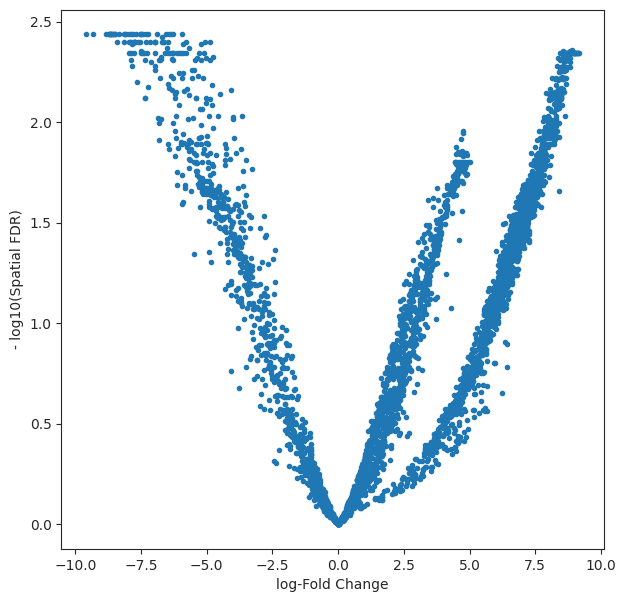

In [48]:
plt.plot(nh_df.logFC, -np.log10(nh_df.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)")

In [49]:
%%R -i nh_df
head(nh_df)

                index_cell kth_distance      logFC   logCPM          F
0 TGGATGTAGGTTAGTA-1_adams     4.185634  4.4574918 7.659003  9.6412981
1 CTGTGAACACTGTTCC-1_adams     3.675650  4.4289577 7.680012 10.2862120
2 TTCCTCTGTATGTCAC-1_adams     3.146324  2.4742605 8.158680  3.9640550
3 GTTAGACTCAACCTTT-1_adams     2.151174 -3.0005382 9.561690  4.4209041
4 TACTTGTAGCGGGTTA-1_adams     3.145792  4.8980461 8.143335  9.6593319
5 GTCCTCAAGACGCCAA-1_adams     2.878739 -0.5237985 8.622492  0.1974608
       PValue        FDR SpatialFDR   Sig Nhood_size nhood_annotation
0 0.002425887 0.01687798 0.01822223  TRUE        472   cycl_Microglia
1 0.001744989 0.01468481 0.01585506  TRUE        483   cycl_Microglia
2 0.048676481 0.09401350 0.09382854  TRUE        487      Microglia_E
3 0.037479072 0.07793130 0.07803354  TRUE        585      Microglia_A
4 0.002400168 0.01678974 0.01811356  TRUE        873   cycl_Microglia
5 0.657540468 0.73480666 0.73118523 FALSE        427      Microglia_A
  nhood_annot

In [50]:
nh_df.to_csv('./MG_figures/nh_df_LPC_demyel_NEW_KEEP_ALL.csv', index=True)  # index=True to include row names

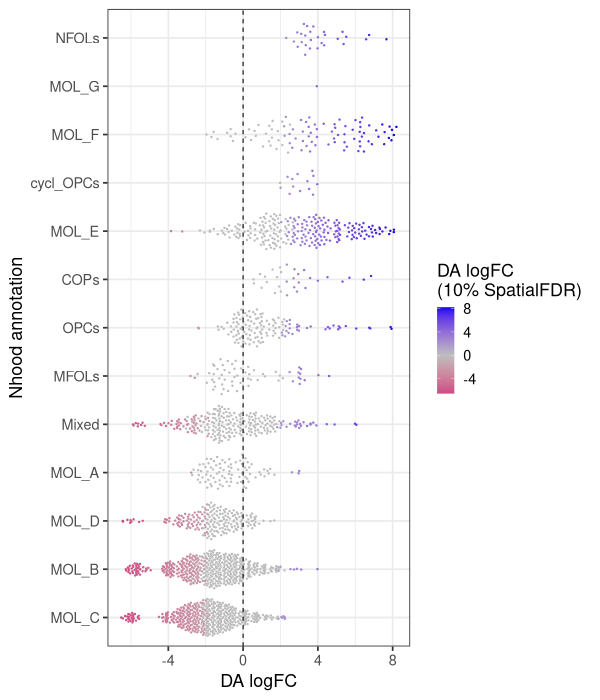

In [140]:
%%R -h 700 -w 600

#figdir <- './sysVI_mm_OL_figures/'

nh_df %>%
  # filter(nhood_annotation_frac > 0.5) %>%
  mutate(signif = ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
  group_by(nhood_annotation) %>%
  mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
  mutate(mean_lfc = mean(mean_lfc_val)) %>%
  ungroup() %>%
  arrange(mean_lfc) %>%
  mutate(nhood_annotation = factor(nhood_annotation, levels = unique(nhood_annotation))) %>%
  ggplot(aes(nhood_annotation, logFC, color = signif)) + 
  ggbeeswarm::geom_quasirandom(size = 0.5) +
  coord_flip() +
  scale_color_gradient2(high = 'blue2', mid = 'grey', low = 'deeppink3', name = 'DA logFC\n(10% SpatialFDR)') +
  theme_bw(base_size = 18) +
  geom_hline(yintercept = 0, linetype = 2) +
  xlab('Nhood annotation') + 
  ylab('DA logFC')
  #ggsave(paste0(figdir, 'beeswarm_fine_anno.png'), width = 10, height = 12) +
  #ggsave(paste0(figdir, 'beeswarm_fine_anno.pdf'), width = 10, height = 12)

In [ ]:
%%R -h 700 -w 600

figdir <- './sysVI_mm_OL_figures/'

nh_df %>%
  mutate(signif = ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
  group_by(nhood_annotation) %>%
  mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
  mutate(mean_lfc = mean(mean_lfc_val)) %>%
  ungroup() %>%
  arrange(mean_lfc) %>%
  mutate(nhood_annotation = factor(nhood_annotation, levels = unique(nhood_annotation))) %>%
  ggplot(aes(nhood_annotation, logFC, color = signif)) + 
  ggbeeswarm::geom_quasirandom(size = 1.5) +  # Increase the size here
  coord_flip() +
  scale_color_gradient2(high = 'blue2', mid = 'grey', low = 'deeppink3', name = 'DA logFC\n(10% SpatialFDR)') +
  theme_bw(base_size = 18) +
  geom_hline(yintercept = 0, linetype = 2) +
  xlab('Nhood annotation') + 
  ylab('DA logFC') +
  #ggsave(paste0(figdir, 'beeswarm_fine_anno.png'), width = 10, height = 12) +
  #ggsave(paste0(figdir, 'beeswarm_fine_anno2.pdf'), width = 10, height = 12)

# Display the plot
print(last_plot())

# Visualize by cell counts

In [ ]:
## Get IDs of plasmablast neighbourhood
pl_nhoods = mdata["milo"].var_names[
    (mdata["milo"].var["SpatialFDR"] < 0.1) & (mdata["milo"].var["nhood_annotation"] == "MOL1")
]

## Visualize cell counts by condition (x-axis) and individuals on all neighbourhoods
milo.plot_nhood_counts_by_cond(mdata, test_var="status", subset_nhoods=pl_nhoods, log_counts=False)

In [ ]:
## Get IDs of plasmablast neighbourhood
pl_nhoods = mdata["milo"].var_names[
    (mdata["milo"].var["SpatialFDR"] < 0.1) & (mdata["milo"].var["nhood_annotation"] == "OPCs")
]

## Visualize cell counts by condition (x-axis) and individuals on all neighbourhoods
milo.plot_nhood_counts_by_cond(mdata, test_var="status", subset_nhoods=pl_nhoods, log_counts=False)

In [ ]:
## Get IDs of plasmablast neighbourhood
pl_nhoods = mdata["milo"].var_names[
    (mdata["milo"].var["SpatialFDR"] < 0.1) & (mdata["milo"].var["nhood_annotation"] == "MFOLs")
]

## Visualize cell counts by condition (x-axis) and individuals on all neighbourhoods
milo.plot_nhood_counts_by_cond(mdata, test_var="status", subset_nhoods=pl_nhoods, log_counts=False)

In [ ]:
## Get IDs of plasmablast neighbourhood
pl_nhoods = mdata["milo"].var_names[
    (mdata["milo"].var["SpatialFDR"] < 0.1) & (mdata["milo"].var["nhood_annotation"] == "MOL2_DAO1")
]

## Visualize cell counts by condition (x-axis) and individuals on all neighbourhoods
milo.plot_nhood_counts_by_cond(mdata, test_var="status", subset_nhoods=pl_nhoods, log_counts=False)

In [ ]:
## Get IDs of plasmablast neighbourhood
pl_nhoods = mdata["milo"].var_names[
    (mdata["milo"].var["SpatialFDR"] < 0.1) & (mdata["milo"].var["nhood_annotation"] == "MOL2")
]

## Visualize cell counts by condition (x-axis) and individuals on all neighbourhoods
milo.plot_nhood_counts_by_cond(mdata, test_var="status", subset_nhoods=pl_nhoods, log_counts=False)

In [ ]:
## Get IDs of plasmablast neighbourhood
pl_nhoods = mdata["milo"].var_names[
    (mdata["milo"].var["SpatialFDR"] < 0.1) & (mdata["milo"].var["nhood_annotation"] == "MOL3")
]

## Visualize cell counts by condition (x-axis) and individuals on all neighbourhoods
milo.plot_nhood_counts_by_cond(mdata, test_var="status", subset_nhoods=pl_nhoods, log_counts=False)

In [ ]:
## Get IDs of plasmablast neighbourhood
pl_nhoods = mdata["milo"].var_names[
    (mdata["milo"].var["SpatialFDR"] < 0.1) & (mdata["milo"].var["nhood_annotation"] == "MOL4")
]

## Visualize cell counts by condition (x-axis) and individuals on all neighbourhoods
milo.plot_nhood_counts_by_cond(mdata, test_var="status", subset_nhoods=pl_nhoods, log_counts=False)

In [ ]:
## Get IDs of plasmablast neighbourhood
pl_nhoods = mdata["milo"].var_names[
    (mdata["milo"].var["SpatialFDR"] < 0.1) & (mdata["milo"].var["nhood_annotation"] == "MOL4_DAO1")
]

## Visualize cell counts by condition (x-axis) and individuals on all neighbourhoods
milo.plot_nhood_counts_by_cond(mdata, test_var="status", subset_nhoods=pl_nhoods, log_counts=False)

# Setting gene expression on DA testing by status

In [ ]:
## Compute average Retnlb expression per neighbourhood
# (you can add mean expression for all genes using milo.utils.add_nhood_expression)
mdata["rna"].obs["DAO_expression"] = (
    mdata["rna"][:, "Serpina3n"].layers["log1p_norm"].toarray().ravel()
)
milo.annotate_nhoods_continuous(mdata, "DAO_expression")
# milo.annotate_nhoods(mdata, "Retnlb_expression")

## Subset to Goblet cell neighbourhoods
nhood_df = mdata["milo"].var.copy()
nhood_df = nhood_df[nhood_df["nhood_annotation"] == "MOL2_DAO1"]

sb.scatterplot(data=nhood_df, x="logFC", y="nhood_DAO_expression")
plt.show()

In [ ]:
## Compute average Retnlb expression per neighbourhood
# (you can add mean expression for all genes using milo.utils.add_nhood_expression)
mdata["rna"].obs["DAO_expression"] = (
    mdata["rna"][:, "C4b"].layers["log1p_norm"].toarray().ravel()
)
milo.annotate_nhoods_continuous(mdata, "DAO_expression")
# milo.annotate_nhoods(mdata, "Retnlb_expression")

## Subset to Goblet cell neighbourhoods
nhood_df = mdata["milo"].var.copy()
nhood_df = nhood_df[nhood_df["nhood_annotation"] == "MOL2_DAO1"]

sb.scatterplot(data=nhood_df, x="logFC", y="nhood_DAO_expression")
plt.show()

In [ ]:
# Compute average Retnlb expression per neighbourhood
mdata["rna"].obs["DAO_expression"] = (
    mdata["rna"][:, "Serpina3n"].layers["log1p_norm"].toarray().ravel()
)
milo.annotate_nhoods_continuous(mdata, "DAO_expression")

# Subset to Goblet cell neighbourhoods
nhood_df = mdata["milo"].var.copy()
nhood_df = nhood_df[nhood_df["nhood_annotation"] == "MOL2_DAO1"]

In [ ]:
nhood_df[:5]

In [ ]:
# Get status for each neighbourhood based on 'index_cell'
nhood_statuses = mdata["rna"].obs.loc[nhood_df.index_cell, "status"].reset_index()
nhood_statuses.columns = ['barcode', 'status']
nhood_statuses[:5]

In [ ]:
# Create a mapping dictionary from nhood_statuses
status_mapping = nhood_statuses.set_index('barcode')['status'].to_dict()

# Map 'status' from nhood_statuses to nhood_df using 'index_cell'
nhood_df['status'] = nhood_df['index_cell'].map(status_mapping)

# Display the updated nhood_df with 'status' column added
nhood_df[:5]

In [ ]:
# Define status to color mapping
status_colors = {
    'control': '#0033ff',
    'LPC_early': '#cc0000',
    'LPC_mid': '#cc6699',
    'LPC_late': '#ffccff',
}

# Map statuses to colors
nhood_df['status_color'] = nhood_df['status'].map(status_colors)
nhood_df[:5]

In [ ]:
# Plot the scatterplot with manual colors
plt.figure(figsize=(8, 6))
sb.scatterplot(data=nhood_df, x="logFC", y="nhood_DAO_expression", c=nhood_df["status_color"], s=50)
plt.xlabel("logFC")
plt.ylabel("nhood_DAO_expression")
plt.title("Scatterplot with 'status' colors")

# Manually create legend
legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=status) for status, color in status_colors.items()]
plt.legend(handles=legend_elements, title="Status", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Saving output

In [132]:
mdata

MuData object with n_obs × n_vars = 25157 × 19913
  2 modalities
    rna:	25157 x 19913
      obs:	'sample_id', 'publication', 'replicate', 'treatment', 'condition', 'time', 'batch', 'lesion_type', 'type_fine', 'type_broad', 'library_type', 'sample_type', 'organism', 'system', 'system_map', 'sys_leiden_1', 'sys_leiden_1.5', 'sys_leiden_2', 'indiv_treatment_time', 'lesion_status', 'lesion_condition', 'S_score', 'G2M_score', 'Cycling cells', 'S phase', 'Cycling_cells', 'S_phase_cells', 'cluster_annotation', 'cell_leiden_annotated', 'common_innate_immunity_signature', 'IRAS1', 'IRAS2', 'leiden_OL_r1', 'leiden_OL_r1.5', 'cell_type_fine', 'OL_type_fine', 'OL_leiden_annotated', 'OL_type_fine_noDAO', 'minimal_treatment_map', 'cluster_annotation_minimal', 'NEW_lesion_condition', 'reduced_map', 'time_treatment', 'time_treatment_pub', 'individual_lesion_condition', 'status', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance', 'cell_type_MILO', 'DAO_expression'
      var:	'hb', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
      uns:	'reduced_map_colors', 'cluster_annotation_minimal_colors', 'cluster_annotation_colors', 'status_colors', 'neighbors', 'nhood_neighbors_key', 'cell_type_MILO_colors'
      obsm:	'X_pca', 'X_sysVI', 'X_umap', 'covariates', 'system', 'nhoods'
      layers:	'counts', 'log1p_norm', 'scaled'
      obsp:	'connectivities', 'distances'
    milo:	16 x 2152
      obs:	'status', 'sample_id'
      var:	'index_cell', 'kth_distance', 'logFC', 'logCPM', 'F', 'PValue', 'FDR', 'SpatialFDR', 'Sig', 'Nhood_size', 'nhood_annotation', 'nhood_annotation_frac', 'nhood_DAO_expression'
      uns:	'sample_col', 'nhood', 'annotation_labels', 'annotation_obs'
      varm:	'X_milo_graph', 'frac_annotation'
      varp:	'nhood_connectivities'

In [133]:
pd.set_option('display.max_columns', None)
mdata['rna'].obs[:5]

sample_id   publication replicate treatment  \
barcode                                                                
GGGACAATCCGGGACT-1_adams       cl2  (this study)         2       LPC   
ATCTTCAGTCCTCATC-1_adams       cl2  (this study)         2       LPC   
GATAGCTAGTAAAGCT-1_adams       cl2  (this study)         2       LPC   
ACGCACGCATGACTCA-1_adams       cl2  (this study)         2       LPC   
TCACGCTGTATACGGG-1_adams       cl2  (this study)         2       LPC   

                              condition  time batch    lesion_type type_fine  \
barcode                                                                        
GGGACAATCCGGGACT-1_adams  Demyelination  7dpl     6  Demyelination       TBD   
ATCTTCAGTCCTCATC-1_adams  Demyelination  7dpl     6  Demyelination       TBD   
GATAGCTAGTAAAGCT-1_adams  Demyelination  7dpl     6  Demyelination       TBD   
ACGCACGCATGACTCA-1_adams  Demyelination  7dpl     6  Demyelination       TBD   
TCACGCTGTATACGGG-1_adams  Demyelination  7dpl     6  Demyelination       TBD   

                                type_broad     library_type sample_type  \
barcode                                                                   
GGGACAATCCGGGACT-1_adams  oligodendrocytes  10X 3p kit v3.1          sn   
ATCTTCAGTCCTCATC-1_adams  oligodendrocytes  10X 3p kit v3.1          sn   
GATAGCTAGTAAAGCT-1_adams  oligodendrocytes  10X 3p kit v3.1          sn   
ACGCACGCATGACTCA-1_adams        astrocytes  10X 3p kit v3.1          sn   
TCACGCTGTATACGGG-1_adams  oligodendrocytes  10X 3p kit v3.1          sn   

                         organism system system_map sys_leiden_1  \
barcode                                                            
GGGACAATCCGGGACT-1_adams    mouse      0   sn-mouse           10   
ATCTTCAGTCCTCATC-1_adams    mouse      0   sn-mouse           10   
GATAGCTAGTAAAGCT-1_adams    mouse      0   sn-mouse           10   
ACGCACGCATGACTCA-1_adams    mouse      0   sn-mouse           13   
TCACGCTGTATACGGG-1_adams    mouse      0   sn-mouse           10   

                         sys_leiden_1.5 sys_leiden_2   indiv_treatment_time  \
barcode                                                                       
GGGACAATCCGGGACT-1_adams             11           29  (this study)_LPC_7dpl   
ATCTTCAGTCCTCATC-1_adams             11           29  (this study)_LPC_7dpl   
GATAGCTAGTAAAGCT-1_adams             11           29  (this study)_LPC_7dpl   
ACGCACGCATGACTCA-1_adams             13           17  (this study)_LPC_7dpl   
TCACGCTGTATACGGG-1_adams             11           14  (this study)_LPC_7dpl   

                                 lesion_status   lesion_condition   S_score  \
barcode                                                                       
GGGACAATCCGGGACT-1_adams  LPC_demyelination_7d  LPC_demyelination -0.203215   
ATCTTCAGTCCTCATC-1_adams  LPC_demyelination_7d  LPC_demyelination -0.232181   
GATAGCTAGTAAAGCT-1_adams  LPC_demyelination_7d  LPC_demyelination -0.264938   
ACGCACGCATGACTCA-1_adams  LPC_demyelination_7d  LPC_demyelination -0.311950   
TCACGCTGTATACGGG-1_adams  LPC_demyelination_7d  LPC_demyelination -0.195632   

                          G2M_score  Cycling cells   S phase Cycling_cells  \
barcode                                                                      
GGGACAATCCGGGACT-1_adams  -0.228369      -0.223877 -0.181960       resting   
ATCTTCAGTCCTCATC-1_adams  -0.248110      -0.254188 -0.222367       resting   
GATAGCTAGTAAAGCT-1_adams  -0.269441      -0.309241 -0.275461       resting   
ACGCACGCATGACTCA-1_adams  -0.377625      -0.392114 -0.304310       resting   
TCACGCTGTATACGGG-1_adams  -0.175837      -0.176384 -0.176660       resting   

                         S_phase_cells cluster_annotation  \
barcode                                                     
GGGACAATCCGGGACT-1_adams            NA                MOL   
ATCTTCAGTCCTCATC-1_adams            NA                MOL   
GATAGCTAGTAAAGCT-1_adams            NA                MOL

In [134]:
mdata['rna']

AnnData object with n_obs × n_vars = 25157 × 19913
    obs: 'sample_id', 'publication', 'replicate', 'treatment', 'condition', 'time', 'batch', 'lesion_type', 'type_fine', 'type_broad', 'library_type', 'sample_type', 'organism', 'system', 'system_map', 'sys_leiden_1', 'sys_leiden_1.5', 'sys_leiden_2', 'indiv_treatment_time', 'lesion_status', 'lesion_condition', 'S_score', 'G2M_score', 'Cycling cells', 'S phase', 'Cycling_cells', 'S_phase_cells', 'cluster_annotation', 'cell_leiden_annotated', 'common_innate_immunity_signature', 'IRAS1', 'IRAS2', 'leiden_OL_r1', 'leiden_OL_r1.5', 'cell_type_fine', 'OL_type_fine', 'OL_leiden_annotated', 'OL_type_fine_noDAO', 'minimal_treatment_map', 'cluster_annotation_minimal', 'NEW_lesion_condition', 'reduced_map', 'time_treatment', 'time_treatment_pub', 'individual_lesion_condition', 'status', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance', 'cell_type_MILO', 'DAO_expression'
    var: 'hb', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log

In [135]:
mdata['milo']

AnnData object with n_obs × n_vars = 16 × 2152
    obs: 'status', 'sample_id'
    var: 'index_cell', 'kth_distance', 'logFC', 'logCPM', 'F', 'PValue', 'FDR', 'SpatialFDR', 'Sig', 'Nhood_size', 'nhood_annotation', 'nhood_annotation_frac', 'nhood_DAO_expression'
    uns: 'sample_col', 'nhood', 'annotation_labels', 'annotation_obs'
    varm: 'X_milo_graph', 'frac_annotation'
    varp: 'nhood_connectivities'

In [136]:
mdata['rna'].write_h5ad('./MILO/mdata_rna_MOL_LPC_EARLY.h5ad')

In [137]:
annotation_labels = list(mdata['milo'].uns['annotation_labels'])
mdata['milo'].uns['annotation_labels'] = annotation_labels
mdata['milo'].write_h5ad('./MILO/mdata_milo_MOL_LPC_EARLY.h5ad')

# Test reading in and creating mudata

In [ ]:
adata1 = sc.read('./mdata_rna_MOL_LPC.h5ad')
adata1

In [ ]:
adata2 = sc.read('./mdata_milo_MOL_LPC.h5ad')
adata2

In [ ]:
# To read in a mudata (multimodal data) use:
import mudata as md
from mudata import MuData

mdata_new = MuData({"rna": adata1, "milo": adata2})
mdata_new

In [ ]:
mdata

In [ ]:
plt.rcParams["figure.figsize"] = [7, 7]
milo.plot_nhood_graph(
    mdata_new,
    alpha=0.5,  ## SpatialFDR level (0.1%)
    min_size=5,  ## Size of smallest dot
    plot_edges=False
)

# Combine with DE analysis??

In [61]:
mdata

MuData object with n_obs × n_vars = 24134 × 19304
  2 modalities
    rna:	24134 x 19304
      obs:	'sample_id', 'publication', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'type_fine', 'type_broad', 'indiv_treatment_time', 'lesion_status', 'lesion_condition', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'S_score', 'G2M_score', 'Cycling cells', 'S phase', 'Cycling_cells', 'S_phase_cells', 'leiden_OL_r1.5', 'individual_lesion_condition', 'OL_broad', 'OL_broad_MOLs', 'OL_leiden_annotated_new', 'minimal_treatment_map', 'OL_fine_type', 'OL_leiden_annotated', 'cell_type', 'OL_fine_type_NEW', 'OL_noDAO_NEW', 'OL_noDAO_NEW_NUMBERED', 'OL_noDAO_NUMBERED', 'n_genes', 'status', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
      var:	'hb', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
      uns:	'OL_broad_MOLs_colors', 'OL_broad_MOLs_sizes', 'OL_broad_colors', 'OL_broad_sizes', 'OL_fine_type_NEW_colors', 'OL_fine_type_colors', 'OL_fine_type_sizes', 'OL_leiden_annotated_colors', 'OL_noDAO_NEW_NUMBERED_colors', 'OL_noDAO_NEW_colors', 'OL_noDAO_NUMBERED_colors', 'cell_type_colors', 'cell_type_sizes', 'dendrogram_OL_broad', 'dendrogram_OL_fine_type', 'dendrogram_OL_fine_type_NEW', 'dendrogram_leiden_OL_r1.5', 'leiden_OL_r1.5_colors', 'minimal_treatment_map_colors', 'neighbors', 'paga', 'publication_colors', 'rank_genes_OL_broad', 'status_colors', 'nhood_neighbors_key'
      obsm:	'X_pca', 'X_sysVI', 'X_umap', 'covariates', 'system', 'nhoods'
      layers:	'counts', 'log1p_norm', 'scaled'
      obsp:	'connectivities', 'distances'
    milo:	14 x 2094
      obs:	'status', 'sample_id'
      var:	'index_cell', 'kth_distance', 'logFC', 'logCPM', 'F', 'PValue', 'FDR', 'SpatialFDR', 'Sig', 'Nhood_size', 'nhood_annotation', 'nhood_annotation_frac'
      uns:	'sample_col', 'nhood', 'annotation_labels', 'annotation_obs'
      varm:	'X_milo_graph', 'frac_annotation'
      varp:	'nhood_connectivities'

In [86]:
mdata['milo'].var

index_cell  kth_distance     logFC     logCPM          F  \
0      CTTGATTTCGTCCTTG-1_adams      4.320025  3.247878   9.823161   9.394449   
1      CTCAATTCACGTACTA-1_adams      3.141347  3.317069  10.323829  12.744866   
2      CTCCCTCTCCTCACCA-1_adams      4.140010  2.307953   9.667914   5.891645   
3      TCACGCTCACTACTTT-1_adams      3.020691  4.336656  10.489662  21.451358   
4      CTCGAGGCACTTCTCG-1_adams      3.031310  3.099437  10.297106   7.228028   
...                         ...           ...       ...        ...        ...   
2089  GTCTACCTCGAAGCAG-1_pandey      3.249618  1.400416   9.507700   1.524400   
2090  TTCGATTGTGAGATAT-1_pandey      1.667780 -1.260029   9.017588   1.768186   
2091  TTGTGGAGTGTCATCA-1_pandey      1.686837  0.629814   9.482899   0.468739   
2092  GCAGCCAGTACCTATG-1_pandey      3.910263  1.737650  10.072956   2.458732   
2093  CTAAGTGTCCGTGTAA-1_pandey      1.930694 -0.127816   9.058206   0.028400   

        PValue       FDR  SpatialFDR    Sig  Nhood_size nhood_annotation  \
0     0.003678  0.018874    0.019576   True        71.0            NFOLs   
1     0.000883  0.007252    0.007860   True        99.0            NFOLs   
2     0.019315  0.056885    0.056582   True        63.0            NFOLs   
3     0.000029  0.000823    0.001056   True        99.0            NFOLs   
4     0.010191  0.036051    0.036352   True       101.0            MFOLs   
...        ...       ...         ...    ...         ...              ...   
2089  0.223538  0.338704    0.331419  False        76.0             OPCs   
2090  0.189777  0.299242    0.292607  False        71.0            MOL_B   
2091  0.497117  0.612971    0.604838  False        99.0            Mixed   
2092  0.124115  0.218218    0.213464  False        96.0             OPCs   
2093  0.866890  0.909909    0.906491  False        69.0            MOL_B   

      nhood_annotation_frac  
0                  1.000000  
1                  1.000000  
2                  0.952381  
3                  0.979798  
4                  0.990099  
...                     ...  
2089               1.000000  
2090               0.901408  
2091               0.565657  
2092               1.000000  
2093               0.913043  

[2094 rows x 12 columns]

In [87]:
import pandas as pd

# Convert the sparse matrix to a dense matrix
nhoods_dense = mdata['rna'].obsm['nhoods'].todense()

# Create a DataFrame for easier manipulation
nhoods_df = pd.DataFrame(nhoods_dense, index=mdata['rna'].obs.index)

# Display the DataFrame to understand its structure
print(nhoods_df.head())

                          0     1     2     3     4     5     6     7     \
barcode                                                                    
GGGACAATCCGGGACT-1_adams   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
ATCTTCAGTCCTCATC-1_adams   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   
GATAGCTAGTAAAGCT-1_adams   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
ACGCACGCATGACTCA-1_adams   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
TCACGCTGTATACGGG-1_adams   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                          8     9     ...  2084  2085  2086  2087  2088  2089  \
barcode                               ...                                       
GGGACAATCCGGGACT-1_adams   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
ATCTTCAGTCCTCATC-1_adams   1.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
GATAGCTAGTAAAGCT-1_adams   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
ACGCACGCATGACTCA-1_adams   0.0   1.0  ...   0.0   0.0   0.0   

In [88]:
# Create a dictionary to store neighborhood assignments
cell_to_nhoods = {cell: list(nhoods_df.columns[nhoods_df.loc[cell].astype(bool)])
                  for cell in nhoods_df.index}

# Example: print neighborhoods for the first few cells
for cell, nhoods in list(cell_to_nhoods.items())[:5]:
    print(f'Cell {cell} is in neighborhoods: {nhoods}')

Cell GGGACAATCCGGGACT-1_adams is in neighborhoods: [50, 375, 381, 557]
Cell ATCTTCAGTCCTCATC-1_adams is in neighborhoods: [4, 8, 50, 152, 374, 375, 557, 558, 784, 1786]
Cell GATAGCTAGTAAAGCT-1_adams is in neighborhoods: [152, 374, 558, 783, 1050, 1051, 1267, 1786, 1793]
Cell ACGCACGCATGACTCA-1_adams is in neighborhoods: [9, 384, 451, 1798, 1835]
Cell TCACGCTGTATACGGG-1_adams is in neighborhoods: [156, 1051, 1266, 1267, 1788, 1789, 1790, 1793]


In [142]:
# Specify the cell of interest
cell_of_interest = 'CTTGATTTCGTCCTTG-1_adams'

# Get the list of neighborhoods for the specified cell
neighborhoods_for_cell = cell_to_nhoods.get(cell_of_interest, [])

# Find the number of neighborhoods
num_neighborhoods = len(neighborhoods_for_cell)

print(f'Number of neighborhoods for cell {cell_of_interest}: {num_neighborhoods}')

Number of neighborhoods for cell CTTGATTTCGTCCTTG-1_adams: 6


In [168]:
nh_df.head()

index_cell  kth_distance     logFC     logCPM          F  \
0  CTTGATTTCGTCCTTG-1_adams      4.320025  3.247878   9.823161   9.394449   
1  CTCAATTCACGTACTA-1_adams      3.141347  3.317069  10.323829  12.744866   
2  CTCCCTCTCCTCACCA-1_adams      4.140010  2.307953   9.667914   5.891645   
3  TCACGCTCACTACTTT-1_adams      3.020691  4.336656  10.489662  21.451358   
4  CTCGAGGCACTTCTCG-1_adams      3.031310  3.099437  10.297106   7.228028   

     PValue       FDR  SpatialFDR   Sig  Nhood_size nhood_annotation  \
0  0.003678  0.018874    0.019576  True        71.0            NFOLs   
1  0.000883  0.007252    0.007860  True        99.0            NFOLs   
2  0.019315  0.056885    0.056582  True        63.0            NFOLs   
3  0.000029  0.000823    0.001056  True        99.0            NFOLs   
4  0.010191  0.036051    0.036352  True       101.0            MFOLs   

   nhood_annotation_frac  
0               1.000000  
1               1.000000  
2               0.952381  
3               0.979798  
4               0.990099

In [169]:
# Create a DataFrame with all rows and only the columns 'Sig' and 'nhood_annotation'
nhood_df_new = nh_df[['Sig', 'logFC', 'SpatialFDR', 'nhood_annotation']]

# Display the new DataFrame
print(nhood_df_new.head())

    Sig     logFC  SpatialFDR nhood_annotation
0  True  3.247878    0.019576            NFOLs
1  True  3.317069    0.007860            NFOLs
2  True  2.307953    0.056582            NFOLs
3  True  4.336656    0.001056            NFOLs
4  True  3.099437    0.036352            MFOLs


In [170]:
# Count the number of True values in the 'Sig' column
num_true_sigs = nhood_df_new['Sig'].sum()

print(f'Number of True Sigs: {num_true_sigs}')

Number of True Sigs: 872


In [171]:
nhood_df_new.shape

(2094, 4)

In [91]:
# Step 1: Extract the neighborhood annotations and map them to neighborhoods
nhood_annotations = mdata['milo'].var['nhood_annotation']
nhood_annotations.head

<bound method NDFrame.head of 0       NFOLs
1       NFOLs
2       NFOLs
3       NFOLs
4       MFOLs
        ...  
2089     OPCs
2090    MOL_B
2091    Mixed
2092     OPCs
2093    MOL_B
Name: nhood_annotation, Length: 2094, dtype: category
Categories (13, object): ['cycl_OPCs' < 'OPCs' < 'COPs' < 'NFOLs' ... 'MOL_E' < 'MOL_F' < 'MOL_G' < 'Mixed']>

In [94]:
# Extract 'index_cell' from mdata['milo'].var
index_cells = mdata['milo'].var['index_cell']

# Ensure nhood_annotations is a DataFrame (if it's not already)
if not isinstance(nhood_annotations, pd.DataFrame):
    nhood_annotations = pd.DataFrame(nhood_annotations)

# Set the index of nhood_annotations to 'index_cell'
nhood_annotations.index = index_cells

# Print to check
nhood_annotations.head

<bound method NDFrame.head of                           nhood_annotation
index_cell                                
CTTGATTTCGTCCTTG-1_adams             NFOLs
CTCAATTCACGTACTA-1_adams             NFOLs
CTCCCTCTCCTCACCA-1_adams             NFOLs
TCACGCTCACTACTTT-1_adams             NFOLs
CTCGAGGCACTTCTCG-1_adams             MFOLs
...                                    ...
GTCTACCTCGAAGCAG-1_pandey             OPCs
TTCGATTGTGAGATAT-1_pandey            MOL_B
TTGTGGAGTGTCATCA-1_pandey            Mixed
GCAGCCAGTACCTATG-1_pandey             OPCs
CTAAGTGTCCGTGTAA-1_pandey            MOL_B

[2094 rows x 1 columns]>

In [62]:
OPC_all = pd.read_csv('/afs/crc.nd.edu/user/e/eaboelno/sysVI_analysis/MM_sysVI_cell_type_refined/DEG_analysis/NEW_OL_DEG/files/LPC_OPC_early_voom_wqw.csv', index_col=None)
OPC_all.rename(columns={'adj.P.Val': 'Padj'}, inplace=True)
OPC_all.rename(columns={'P.Value': 'Pvalue'}, inplace=True)
OPC_all.shape

(8688, 7)

In [63]:
OPC_all.head()

gene     logFC   AveExpr          t        Pvalue          Padj  \
0        C4b  4.991548  5.148658  18.088164  1.117082e-11  6.826179e-08   
1     Dbndd2  4.543842  4.764972  17.668007  1.571404e-11  6.826179e-08   
2  Serpina3n  5.026431  5.556402  16.069562  6.180884e-11  1.789984e-07   
3    Col16a1  2.324589  5.868535  15.690280  8.709132e-11  1.891623e-07   
4      Moxd1  3.784899  3.825564  14.492781  2.704537e-10  4.699404e-07   

           B  
0  16.503608  
1  16.299011  
2  15.264814  
3  15.041971  
4  13.438469

In [64]:
# Filter for upregulated genes
OPC_up = OPC_all[(OPC_all.Padj < 0.05) & (OPC_all.logFC >= 1)]
print(OPC_up.shape)

# Filter for downregulated genes
OPC_down = OPC_all[(OPC_all.Padj < 0.05) & (OPC_all.logFC <= -1)]
print(OPC_down.shape)

(239, 7)
(352, 7)


In [97]:
mdata['rna'].var

hb   ribo  n_cells_by_counts  mean_counts  \
gene_name                                                     
0610005C13Rik  False  False                366     0.003838   
0610006L08Rik  False  False                 28     0.000224   
0610009B22Rik  False  False              20891     0.154660   
0610009E02Rik  False  False               1278     0.011051   
0610009L18Rik  False  False               7273     0.054099   
...              ...    ...                ...          ...   
mt-Nd3         False  False              62277     0.965920   
mt-Nd4         False  False              84428     2.135466   
mt-Nd4l        False  False              46152     0.589277   
mt-Nd5         False  False              55928     0.657394   
mt-Nd6         False  False              13171     0.088099   

               log1p_mean_counts  pct_dropout_by_counts   total_counts  \
gene_name                                                                
0610005C13Rik           0.003830              99.673264     429.902985   
0610006L08Rik           0.000224              99.975004      25.082155   
0610009B22Rik           0.143806              81.350152   17324.503906   
0610009E02Rik           0.010990              98.859102    1237.851440   
0610009L18Rik           0.052686              93.507236    6059.995117   
...                          ...                    ...            ...   
mt-Nd3                  0.675960              44.403974  108199.921875   
mt-Nd4                  1.142778              24.629297  239208.593750   
mt-Nd4l                 0.463279              58.799111   66008.976562   
mt-Nd5                  0.505247              50.071864   73639.539062   
mt-Nd6                  0.084432              88.241963    9868.625977   

               log1p_total_counts  n_cells  
gene_name                                   
0610005C13Rik            6.065883      109  
0610006L08Rik            3.261251       17  
0610009B22Rik            9.759935     7301  
0610009E02Rik            7.121940      261  
0610009L18Rik            8.709629     2054  
...                           ...      ...  
mt-Nd3                  11.591745    16989  
mt-Nd4                  12.385096    17510  
mt-Nd4l                 11.097561    16491  
mt-Nd5                  11.206951    15148  
mt-Nd6                   9.197217     4694  

[19304 rows x 9 columns]

In [98]:
print(expr_data.head)

<bound method NDFrame.head of gene_name                  0610005C13Rik  0610006L08Rik  0610009B22Rik  \
barcode                                                                  
GGGACAATCCGGGACT-1_adams               0              0              0   
ATCTTCAGTCCTCATC-1_adams               0              0              0   
GATAGCTAGTAAAGCT-1_adams               0              0              0   
ACGCACGCATGACTCA-1_adams               0              0       0.635863   
TCACGCTGTATACGGG-1_adams               0              0              0   
...                                  ...            ...            ...   
AAACCCATCCATATGG-1_pandey              0              0              0   
GCGGAAAAGCGGTAGT-1_pandey              0              0              0   
GAGTTACAGAGTATAC-1_pandey              0              0              0   
GATCAGTAGAATTGCA-1_pandey              0              0              0   
GGAATCTTCACTGGGC-1_pandey              0              0              0   

gene_na

In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Extract and Transform Expression Data
expr_matrix = mdata['rna'].layers['log1p_norm']  # Expression matrix in sparse format

# Inspect the shape of the matrix
print("Expression Matrix Shape:", expr_matrix.shape)  # (24134, 19304)
print("Number of Genes:", len(mdata['rna'].var.index))  # Should be 19304
print("Number of Cells:", len(mdata['rna'].obs.index))  # Should be 24134

# Create DataFrame with genes as rows and cells as columns
expr_data = pd.DataFrame.sparse.from_spmatrix(
    expr_matrix.T,  # Transpose here
    index=mdata['rna'].var.index,  # Genes
    columns=mdata['rna'].obs.index  # Cells
)

# Check the first few rows to ensure proper format
print("Expression Data Head:")
print(expr_data.head())

Expression Matrix Shape: (24134, 19304)
Number of Genes: 19304
Number of Cells: 24134
Expression Data Head:
barcode        GGGACAATCCGGGACT-1_adams  ATCTTCAGTCCTCATC-1_adams  \
gene_name                                                           
0610005C13Rik                         0                         0   
0610006L08Rik                         0                         0   
0610009B22Rik                         0                         0   
0610009E02Rik                         0                         0   
0610009L18Rik                         0                         0   

barcode        GATAGCTAGTAAAGCT-1_adams  ACGCACGCATGACTCA-1_adams  \
gene_name                                                           
0610005C13Rik                         0                         0   
0610006L08Rik                         0                         0   
0610009B22Rik                         0                  0.635863   
0610009E02Rik                         0                        

In [105]:
# Ensure the neighborhood DataFrame has the right columns
nhoods_df.columns = [f'Neighborhood_{i}' for i in range(nhoods.shape[1])]

# Step 3: Filter for Upregulated Genes
OPC_up_genes = OPC_up['gene'].tolist()  # List of upregulated genes
print("Upregulated Genes List:")
print(OPC_up_genes)

# Check if these genes are in the columns of expr_data
missing_genes = [gene for gene in OPC_up_genes if gene not in expr_data.index]
print("Missing Genes:")
print(missing_genes)

# Filter expression data for these genes, if no missing genes
if not missing_genes:
    expr_data_filtered = expr_data.loc[OPC_up_genes]  # Filter expression data for these genes
else:
    print("Some genes are missing from the expression data rows. Please check the gene names.")

# Step 4: Calculate Average Expression for Each Neighborhood
# Create an empty DataFrame to store results
average_expression_per_nhood = pd.DataFrame(index=expr_data_filtered.index)

# Loop through each neighborhood and calculate average expression
for nhood in nhoods_df.columns:
    # Get the cells in this neighborhood
    cells_in_nhood = nhoods_df[nhood] > 0
    
    # Filter expression data for these cells
    expr_in_nhood = expr_data_filtered.loc[:, cells_in_nhood]
    
    # Calculate mean expression per gene for these cells
    mean_expr = expr_in_nhood.mean(axis=1)  # Change to axis=1 to get mean for each gene
    
    # Store results in the DataFrame
    average_expression_per_nhood[nhood] = mean_expr

Upregulated Genes List:
['C4b', 'Dbndd2', 'Serpina3n', 'Col16a1', 'Moxd1', 'Josd2', 'Ajap1', 'Slc48a1', 'Irgm1', 'Ndst3', 'Glis3', 'Ermard', 'Slc14a1', 'Bmpr1b', 'Col20a1', 'Hpgd', 'Gas7', 'Nlrc5', 'Nfkbia', 'Cers2', 'Ifit1', 'Desi1', 'Itga1', 'Rnf220', 'Gng11', 'Fstl4', 'Aatk', 'Sbno2', 'Vim', 'Snhg4', 'Piezo2', 'Cldn11', 'Litaf', 'Rgl1', 'Cela1', 'Sdk2', 'Gm42047', 'Qdpr', '9030025P20Rik', 'Fbxo2', 'Pdgfa', '2310039H08Rik', 'Tmbim1', 'Adamts9', 'Ddx60', 'Atp1b2', 'Aldh1l2', 'Pvt1', 'Gm11808', 'Irf9', 'Ehd1', 'Fxyd7', 'Vwf', 'Id3', 'Tvp23a', 'Phgdh', 'Col11a1', 'Cpox', 'Gadd45b', 'Gpx3', 'Vcam1', '2810410L24Rik', 'Agpat4', 'Sort1', 'Enc1', 'Rtp4', 'Ift43', 'Klf13', 'Arl2', 'Gadd45g', 'Adamtsl3', 'Gm17018', 'Rnd3', 'Sv2c', 'Tmem176a', 'Arhgef10', 'Gfap', 'Gm26673', 'Map7d1', 'Kcna1', 'Dmrtb1', 'Rnf213', 'Cebpd', 'St18', 'Chmp7', 'Neat1', 'Nipsnap3b', 'Fam174b', '2310011J03Rik', 'Iah1', 'Ddx58', 'Acot7', 'Gap43', 'Ttll7', 'Zfp579', 'Lap3', 'Iqsec1', 'Col9a3', 'Cavin3', 'Ybx3', 'Tspan2',

In [108]:
average_expression_per_nhood.shape

(239, 2094)

In [106]:
average_expression_per_nhood.head

<bound method NDFrame.head of            Neighborhood_0  Neighborhood_1  Neighborhood_2  Neighborhood_3  \
gene_name                                                                   
C4b              0.279131        0.255912         0.19602        0.052081   
Dbndd2            1.22904        1.472627        1.138115         1.41935   
Serpina3n         0.28121          0.3399        0.114048         0.22274   
Col16a1          0.368371        0.357994        0.344688        0.398742   
Moxd1            0.030462        0.083138        0.052385        0.010599   
...                   ...             ...             ...             ...   
Rps16             0.37389        0.758086         0.45828        0.843645   
Rplp0            0.355973        0.807934         0.52559        0.868462   
Rps12            0.362052        0.714323         0.55422        0.681561   
Rps7             0.536216        0.992894        0.530701        1.157162   
Rpl18a           0.465242        0.917078     

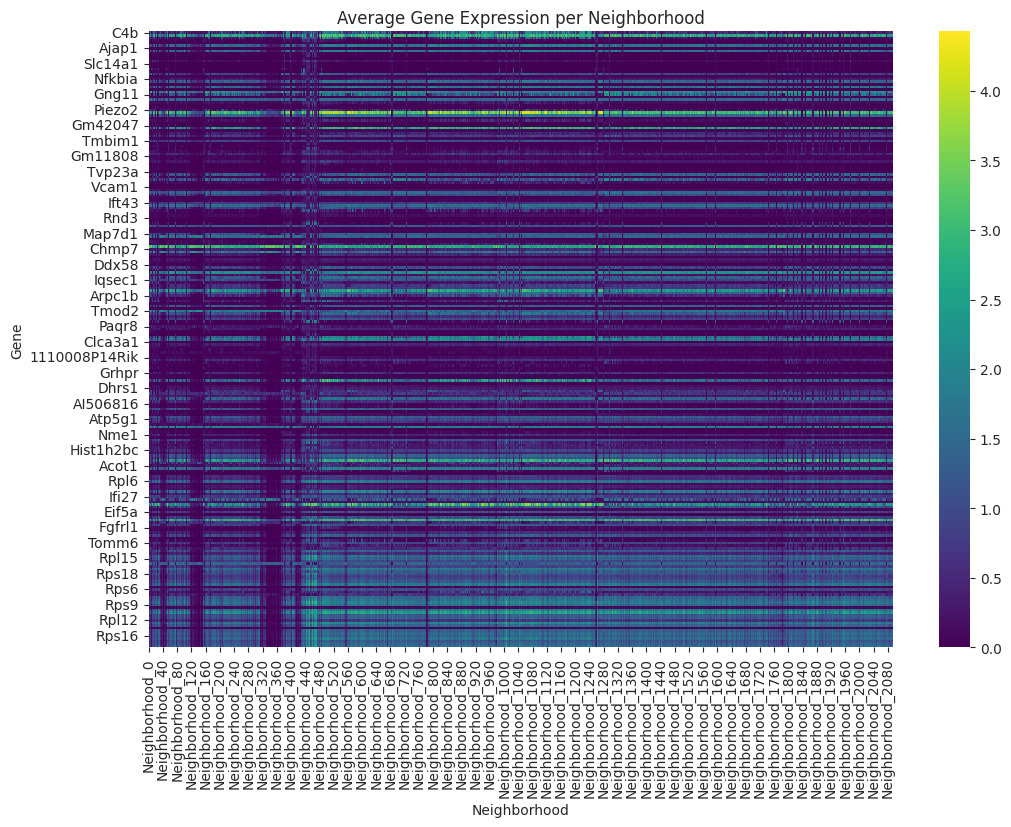

In [107]:
# Step 5: Save or Visualize the Results
# Save to CSV
# average_expression_per_nhood.to_csv('./average_expression_per_nhood.csv')

# Optionally, plot a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(average_expression_per_nhood, cmap='viridis', cbar=True)
plt.title('Average Gene Expression per Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Gene')
plt.show()

# ADAPT VARIABLES IN DATA

In [172]:
nhood_df_new

Sig     logFC  SpatialFDR nhood_annotation
0      True  3.247878    0.019576            NFOLs
1      True  3.317069    0.007860            NFOLs
2      True  2.307953    0.056582            NFOLs
3      True  4.336656    0.001056            NFOLs
4      True  3.099437    0.036352            MFOLs
...     ...       ...         ...              ...
2089  False  1.400416    0.331419             OPCs
2090  False -1.260029    0.292607            MOL_B
2091  False  0.629814    0.604838            Mixed
2092  False  1.737650    0.213464             OPCs
2093  False -0.127816    0.906491            MOL_B

[2094 rows x 4 columns]

In [173]:
# Filter for upregulated genes
nhood_UP = nhood_df_new[(nhood_df_new.Sig == True) & (nhood_df_new.logFC > 0)]
print(nhood_UP.shape)

(346, 4)


In [174]:
# Filter for upregulated genes
nhood_down = nhood_df_new[(nhood_df_new.Sig == True) & (nhood_df_new.logFC < 0)]
print(nhood_down.shape)

(526, 4)


In [115]:
# Step 1: Extract the neighborhood annotations and map them to neighborhoods
nhood_annotations = mdata['milo'].var['nhood_annotation']
nhood_annotations.head

<bound method NDFrame.head of 0       NFOLs
1       NFOLs
2       NFOLs
3       NFOLs
4       MFOLs
        ...  
2089     OPCs
2090    MOL_B
2091    Mixed
2092     OPCs
2093    MOL_B
Name: nhood_annotation, Length: 2094, dtype: category
Categories (13, object): ['cycl_OPCs' < 'OPCs' < 'COPs' < 'NFOLs' ... 'MOL_E' < 'MOL_F' < 'MOL_G' < 'Mixed']>

In [124]:
# Create a mapping from neighborhood index to annotations
nhood_mapping = nhood_annotations.to_dict()
print(nhood_annotations.shape)

(2094,)


In [128]:
# Step 1: Extract the neighborhood annotations
nhood_annotations = mdata['milo'].var['nhood_annotation'].to_list()

# Step 2: Create new column names combining indices and annotations
new_column_names = [f'Neighborhood_{i}_{nhood_annotations[i]}' for i in range(len(nhood_annotations))]

# Step 3: Rename the columns in average_expression_per_nhood
average_expression_per_nhood.columns = new_column_names

# Display the updated DataFrame with new column names
print(average_expression_per_nhood.head())

          Neighborhood_0_NFOLs Neighborhood_1_NFOLs Neighborhood_2_NFOLs  \
gene_name                                                                  
C4b                   0.279131             0.255912              0.19602   
Dbndd2                 1.22904             1.472627             1.138115   
Serpina3n              0.28121               0.3399             0.114048   
Col16a1               0.368371             0.357994             0.344688   
Moxd1                 0.030462             0.083138             0.052385   

          Neighborhood_3_NFOLs Neighborhood_4_MFOLs Neighborhood_5_Mixed  \
gene_name                                                                  
C4b                   0.052081             0.084716             1.709145   
Dbndd2                 1.41935             1.120855             2.225835   
Serpina3n              0.22274             0.077239             0.977357   
Col16a1               0.398742             0.050477             0.039857   
Moxd1      

In [137]:
print("Column Names:", average_expression_per_nhood.columns.tolist() [:5])

Column Names: ['Neighborhood_0_NFOLs', 'Neighborhood_1_NFOLs', 'Neighborhood_2_NFOLs', 'Neighborhood_3_NFOLs', 'Neighborhood_4_MFOLs']


In [148]:
# Extract the column name at index 10
column_name = average_expression_per_nhood.columns[10]

print(f'Column name at index 10: {column_name}')

Column name at index 10: Neighborhood_10_COPs


In [151]:
nhood_df_new.tail

<bound method NDFrame.tail of         Sig nhood_annotation
0      True            NFOLs
1      True            NFOLs
2      True            NFOLs
3      True            NFOLs
4      True            MFOLs
...     ...              ...
2089  False             OPCs
2090  False            MOL_B
2091  False            Mixed
2092  False             OPCs
2093  False            MOL_B

[2094 rows x 2 columns]>

In [175]:
# Display the new DataFrame
nhood_df_new[:11]

Sig     logFC  SpatialFDR nhood_annotation
0    True  3.247878    0.019576            NFOLs
1    True  3.317069    0.007860            NFOLs
2    True  2.307953    0.056582            NFOLs
3    True  4.336656    0.001056            NFOLs
4    True  3.099437    0.036352            MFOLs
5   False  0.999862    0.479092            Mixed
6    True  2.700522    0.032958             COPs
7    True  3.624715    0.009299            NFOLs
8    True  4.026522    0.019072            MFOLs
9    True  2.488940    0.057317             OPCs
10  False  1.706015    0.144767             COPs

In [176]:
# Create the 'names' column by combining the prefix, index, and annotation
nhood_df_new['names'] = ['Neighborhood_{}_{}'.format(index, annotation) 
                         for index, annotation in zip(nhood_df_new.index, nhood_df_new['nhood_annotation'])]

# Display the DataFrame to check the new column
print(nhood_df_new.head())

    Sig     logFC  SpatialFDR nhood_annotation                 names
0  True  3.247878    0.019576            NFOLs  Neighborhood_0_NFOLs
1  True  3.317069    0.007860            NFOLs  Neighborhood_1_NFOLs
2  True  2.307953    0.056582            NFOLs  Neighborhood_2_NFOLs
3  True  4.336656    0.001056            NFOLs  Neighborhood_3_NFOLs
4  True  3.099437    0.036352            MFOLs  Neighborhood_4_MFOLs


/tmp/822151.1.gpu/ipykernel_3805350/3372169897.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nhood_df_new['names'] = ['Neighborhood_{}_{}'.format(index, annotation)


In [153]:
# Create a dictionary where 'names' is the key and 'Sig' is the value
name_sig_dict = dict(zip(nhood_df_new['names'], nhood_df_new['Sig']))

# Display the dictionary
print("Name-Sig Dictionary:", name_sig_dict)

Name-Sig Dictionary: {'Neighborhood_0_NFOLs': True, 'Neighborhood_1_NFOLs': True, 'Neighborhood_2_NFOLs': True, 'Neighborhood_3_NFOLs': True, 'Neighborhood_4_MFOLs': True, 'Neighborhood_5_Mixed': False, 'Neighborhood_6_COPs': True, 'Neighborhood_7_NFOLs': True, 'Neighborhood_8_MFOLs': True, 'Neighborhood_9_OPCs': True, 'Neighborhood_10_COPs': False, 'Neighborhood_11_MFOLs': True, 'Neighborhood_12_MOL_B': False, 'Neighborhood_13_MOL_C': False, 'Neighborhood_14_MFOLs': True, 'Neighborhood_15_MOL_E': False, 'Neighborhood_16_Mixed': False, 'Neighborhood_17_MOL_E': True, 'Neighborhood_18_OPCs': False, 'Neighborhood_19_COPs': False, 'Neighborhood_20_MOL_F': False, 'Neighborhood_21_MOL_C': False, 'Neighborhood_22_MOL_B': False, 'Neighborhood_23_cycl_OPCs': True, 'Neighborhood_24_OPCs': False, 'Neighborhood_25_MOL_C': False, 'Neighborhood_26_MOL_B': False, 'Neighborhood_27_COPs': True, 'Neighborhood_28_OPCs': True, 'Neighborhood_29_OPCs': False, 'Neighborhood_30_MOL_B': False, 'Neighborhood_31

In [154]:
# Filter columns in average_expression_per_nhood where Sig is True
columns_to_keep = [name for name, sig in name_sig_dict.items() if sig]

# Assuming average_expression_per_nhood is your DataFrame
# Filter the DataFrame columns
filtered_expression_df = average_expression_per_nhood[columns_to_keep]

# Display the filtered DataFrame
print(filtered_expression_df.head())

          Neighborhood_0_NFOLs Neighborhood_1_NFOLs Neighborhood_2_NFOLs  \
gene_name                                                                  
C4b                   0.279131             0.255912              0.19602   
Dbndd2                 1.22904             1.472627             1.138115   
Serpina3n              0.28121               0.3399             0.114048   
Col16a1               0.368371             0.357994             0.344688   
Moxd1                 0.030462             0.083138             0.052385   

          Neighborhood_3_NFOLs Neighborhood_4_MFOLs Neighborhood_6_COPs  \
gene_name                                                                 
C4b                   0.052081             0.084716            0.585686   
Dbndd2                 1.41935             1.120855            1.729587   
Serpina3n              0.22274             0.077239            0.240552   
Col16a1               0.398742             0.050477            0.251904   
Moxd1            

In [156]:
# Convert all columns to numeric, forcing errors to NaN
filtered_expression_df = filtered_expression_df.apply(pd.to_numeric, errors='coerce')

# Drop rows or columns with all NaN values if necessary
filtered_expression_df = filtered_expression_df.dropna(axis=1, how='all')
filtered_expression_df = filtered_expression_df.dropna(axis=0, how='all')

In [159]:
# Display the filtered DataFrame
print(filtered_expression_df.head())

           Neighborhood_0_NFOLs  Neighborhood_1_NFOLs  Neighborhood_2_NFOLs  \
gene_name                                                                     
C4b                    0.279131              0.255912              0.196020   
Dbndd2                 1.229040              1.472627              1.138115   
Serpina3n              0.281210              0.339900              0.114048   
Col16a1                0.368371              0.357994              0.344688   
Moxd1                  0.030462              0.083138              0.052385   

           Neighborhood_3_NFOLs  Neighborhood_4_MFOLs  Neighborhood_6_COPs  \
gene_name                                                                    
C4b                    0.052081              0.084716             0.585686   
Dbndd2                 1.419350              1.120855             1.729587   
Serpina3n              0.222740              0.077239             0.240552   
Col16a1                0.398742              0.050477   

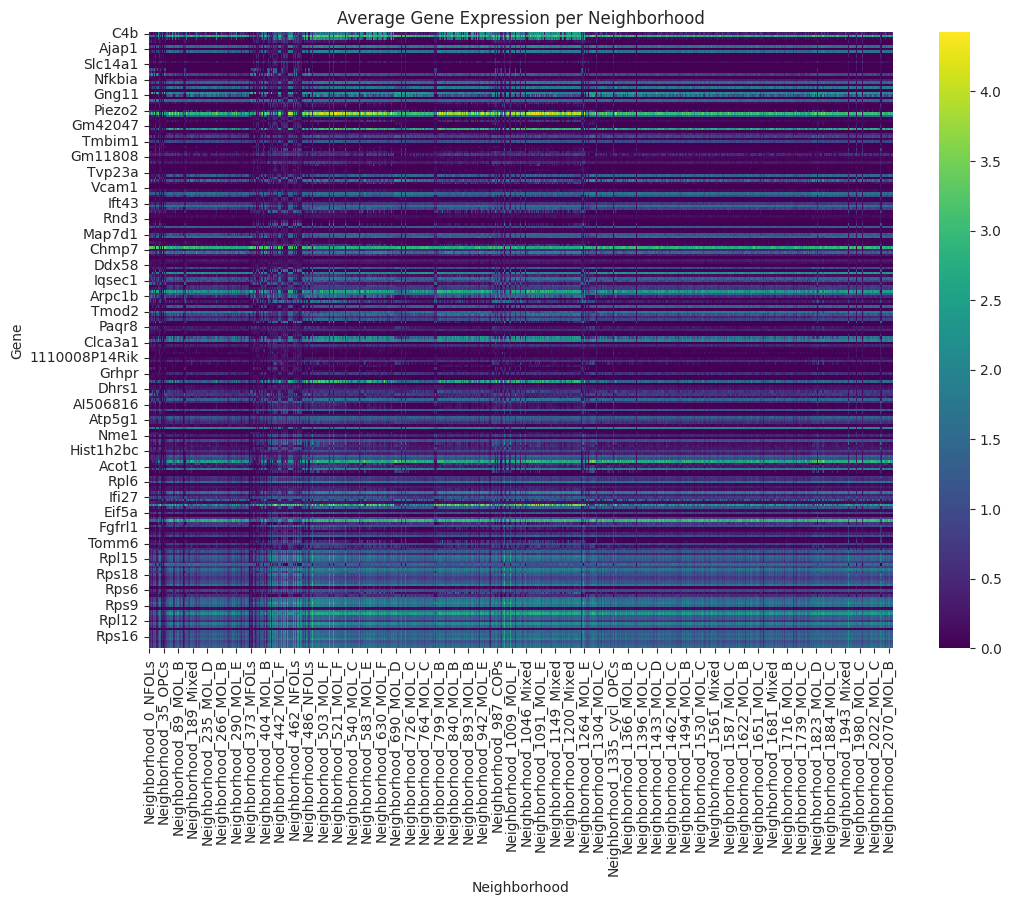

In [157]:
# Optionally, plot a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_expression_df, cmap='viridis', cbar=True)
plt.title('Average Gene Expression per Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Gene')
plt.show()

In [165]:
# Desired cell types order
desired_cell_types_order = ['cycl_OPCs', 'OPCs', 'COPs', 'NFOLs', 'MFOLs', 'MOL_A', 'MOL_B', 'MOL_C', 'MOL_D', 'MOL_E', 'MOL_F', 'MOL_G']

# Extract cell type and neighborhood index from column names
def extract_info(col_name):
    parts = col_name.split('_')
    nhood_index = int(parts[1])
    cell_type = parts[2]
    return (cell_type, nhood_index)

# Sort columns based on cell type and neighborhood index
sorted_columns = sorted(
    filtered_expression_df.columns,
    key=lambda col_name: (
        desired_cell_types_order.index(extract_info(col_name)[0]) if extract_info(col_name)[0] in desired_cell_types_order else float('inf'),
        extract_info(col_name)[1]
    )
)

# Reorder DataFrame columns
filtered_expression_df_sorted = filtered_expression_df[sorted_columns]

# Display the reordered DataFrame
print(filtered_expression_df_sorted.head())

           Neighborhood_9_OPCs  Neighborhood_28_OPCs  Neighborhood_31_OPCs  \
gene_name                                                                    
C4b                   0.390106              0.069255              0.093999   
Dbndd2                0.183172              0.000000              0.000000   
Serpina3n             0.426184              0.020849              0.000000   
Col16a1               0.345588              0.079883              0.082977   
Moxd1                 0.223565              0.027887              0.047439   

           Neighborhood_35_OPCs  Neighborhood_378_OPCs  Neighborhood_382_OPCs  \
gene_name                                                                       
C4b                    0.082927               0.392328               0.495507   
Dbndd2                 0.007869               0.250155               0.279041   
Serpina3n              0.007869               0.114656               0.261165   
Col16a1                0.046033               0.

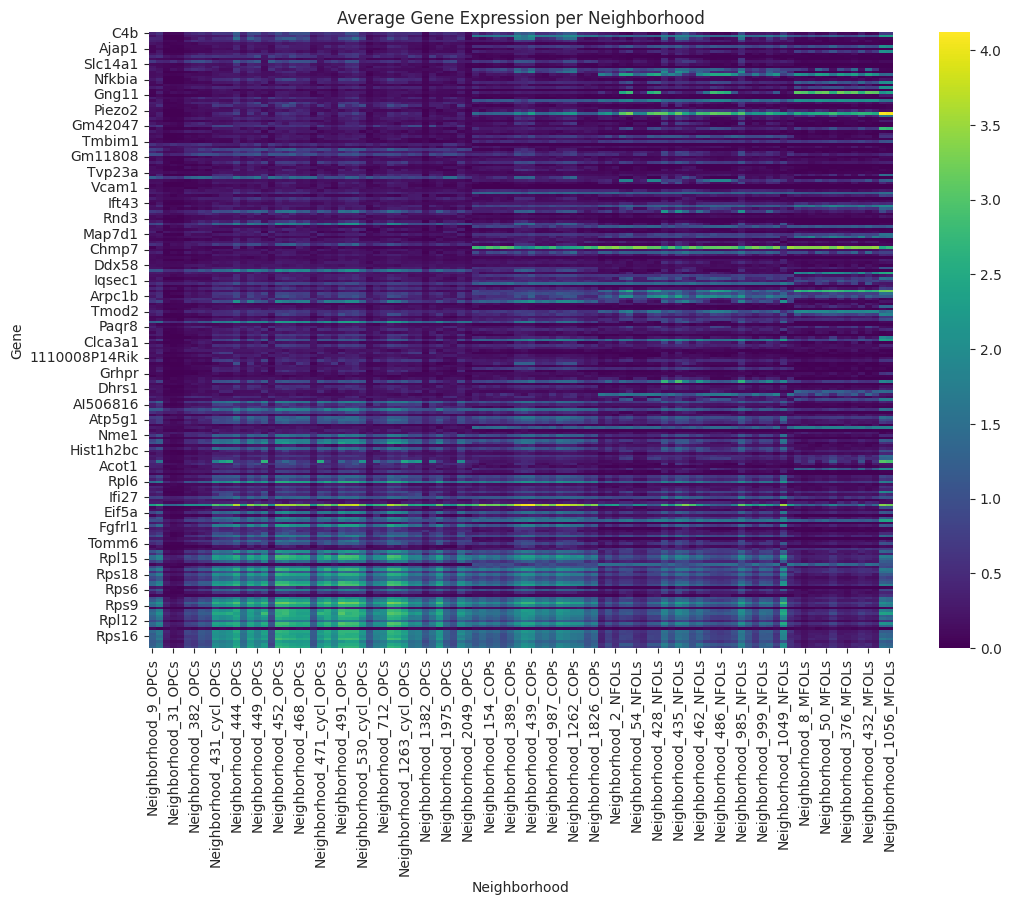

In [166]:
# Optionally, plot a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(sorted_expression_df, cmap='viridis', cbar=True)
plt.title('Average Gene Expression per Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Gene')
plt.show()

# ORDERED HEAT MAP

In [62]:
OPC_all = pd.read_csv('/afs/crc.nd.edu/user/e/eaboelno/sysVI_analysis/MM_sysVI_cell_type_refined/DEG_analysis/NEW_OL_DEG/files/LPC_OPC_early_voom_wqw.csv', index_col=None)
OPC_all.rename(columns={'adj.P.Val': 'Padj'}, inplace=True)
OPC_all.rename(columns={'P.Value': 'Pvalue'}, inplace=True)
OPC_all.shape

(8688, 7)

In [63]:
OPC_all.head()

gene     logFC   AveExpr          t        Pvalue          Padj  \
0        C4b  4.991548  5.148658  18.088164  1.117082e-11  6.826179e-08   
1     Dbndd2  4.543842  4.764972  17.668007  1.571404e-11  6.826179e-08   
2  Serpina3n  5.026431  5.556402  16.069562  6.180884e-11  1.789984e-07   
3    Col16a1  2.324589  5.868535  15.690280  8.709132e-11  1.891623e-07   
4      Moxd1  3.784899  3.825564  14.492781  2.704537e-10  4.699404e-07   

           B  
0  16.503608  
1  16.299011  
2  15.264814  
3  15.041971  
4  13.438469

In [178]:
# Filter for significant genes (Padj < 0.05) and log fold change (|logFC| >= 1)
OPC_sig = OPC_all[(OPC_all['Padj'] < 0.05) & (OPC_all['logFC'].abs() >= 1)]

OPC_sig = OPC_sig.sort_values(by='logFC', ascending=False)

# Display the shape and head of the filtered DataFrame
print(OPC_sig.shape)
print(OPC_sig.head())

(591, 7)
        gene     logFC   AveExpr         t        Pvalue      Padj         B
138     Gfap  7.334799  4.024009  6.385832  1.161777e-05  0.000726  2.811734
328  S100a10  6.718105  3.016471  5.237381  9.676586e-05  0.002555  1.196230
35    Cldn11  6.476761  3.919628  8.880320  2.132599e-07  0.000051  7.217379
161    Neat1  6.390987  3.517373  6.160776  1.735368e-05  0.000929  2.692092
123     Sv2c  5.938852  3.792508  6.518593  9.199027e-06  0.000639  3.541025


In [179]:
import pandas as pd

# Convert the sparse matrix to a dense matrix
nhoods_dense = mdata['rna'].obsm['nhoods'].todense()

# Create a DataFrame for easier manipulation
nhoods_df = pd.DataFrame(nhoods_dense, index=mdata['rna'].obs.index)

# Display the DataFrame to understand its structure
print(nhoods_df.head())

                          0     1     2     3     4     5     6     7     \
barcode                                                                    
GGGACAATCCGGGACT-1_adams   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
ATCTTCAGTCCTCATC-1_adams   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   
GATAGCTAGTAAAGCT-1_adams   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
ACGCACGCATGACTCA-1_adams   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
TCACGCTGTATACGGG-1_adams   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                          8     9     ...  2084  2085  2086  2087  2088  2089  \
barcode                               ...                                       
GGGACAATCCGGGACT-1_adams   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
ATCTTCAGTCCTCATC-1_adams   1.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
GATAGCTAGTAAAGCT-1_adams   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
ACGCACGCATGACTCA-1_adams   0.0   1.0  ...   0.0   0.0   0.0   

In [180]:
# Create a dictionary to store neighborhood assignments
cell_to_nhoods = {cell: list(nhoods_df.columns[nhoods_df.loc[cell].astype(bool)])
                  for cell in nhoods_df.index}

# Example: print neighborhoods for the first few cells
for cell, nhoods in list(cell_to_nhoods.items())[:5]:
    print(f'Cell {cell} is in neighborhoods: {nhoods}')

Cell GGGACAATCCGGGACT-1_adams is in neighborhoods: [50, 375, 381, 557]
Cell ATCTTCAGTCCTCATC-1_adams is in neighborhoods: [4, 8, 50, 152, 374, 375, 557, 558, 784, 1786]
Cell GATAGCTAGTAAAGCT-1_adams is in neighborhoods: [152, 374, 558, 783, 1050, 1051, 1267, 1786, 1793]
Cell ACGCACGCATGACTCA-1_adams is in neighborhoods: [9, 384, 451, 1798, 1835]
Cell TCACGCTGTATACGGG-1_adams is in neighborhoods: [156, 1051, 1266, 1267, 1788, 1789, 1790, 1793]


In [181]:
# Specify the cell of interest
cell_of_interest = 'CTTGATTTCGTCCTTG-1_adams'

# Get the list of neighborhoods for the specified cell
neighborhoods_for_cell = cell_to_nhoods.get(cell_of_interest, [])

# Find the number of neighborhoods
num_neighborhoods = len(neighborhoods_for_cell)

print(f'Number of neighborhoods for cell {cell_of_interest}: {num_neighborhoods}')

Number of neighborhoods for cell CTTGATTTCGTCCTTG-1_adams: 6


In [182]:
nh_df.head()

index_cell  kth_distance     logFC     logCPM          F  \
0  CTTGATTTCGTCCTTG-1_adams      4.320025  3.247878   9.823161   9.394449   
1  CTCAATTCACGTACTA-1_adams      3.141347  3.317069  10.323829  12.744866   
2  CTCCCTCTCCTCACCA-1_adams      4.140010  2.307953   9.667914   5.891645   
3  TCACGCTCACTACTTT-1_adams      3.020691  4.336656  10.489662  21.451358   
4  CTCGAGGCACTTCTCG-1_adams      3.031310  3.099437  10.297106   7.228028   

     PValue       FDR  SpatialFDR   Sig  Nhood_size nhood_annotation  \
0  0.003678  0.018874    0.019576  True        71.0            NFOLs   
1  0.000883  0.007252    0.007860  True        99.0            NFOLs   
2  0.019315  0.056885    0.056582  True        63.0            NFOLs   
3  0.000029  0.000823    0.001056  True        99.0            NFOLs   
4  0.010191  0.036051    0.036352  True       101.0            MFOLs   

   nhood_annotation_frac  
0               1.000000  
1               1.000000  
2               0.952381  
3               0.979798  
4               0.990099

In [183]:
# Create a DataFrame with all rows and only the columns 'Sig' and 'nhood_annotation'
nhood_df_new = nh_df[['Sig', 'logFC', 'SpatialFDR', 'nhood_annotation']]

# Display the new DataFrame
print(nhood_df_new.head())

    Sig     logFC  SpatialFDR nhood_annotation
0  True  3.247878    0.019576            NFOLs
1  True  3.317069    0.007860            NFOLs
2  True  2.307953    0.056582            NFOLs
3  True  4.336656    0.001056            NFOLs
4  True  3.099437    0.036352            MFOLs


In [185]:
# Filter for significant genes (Padj < 0.05) and log fold change (|logFC| >= 1)
nhood_sig = nhood_df_new[(nhood_df_new['Sig'] == True) & (nhood_df_new['logFC'].abs() >= 0)]

nhood_sig = nhood_sig.sort_values(by='logFC', ascending=False)

# Display the shape and head of the filtered DataFrame
print(nhood_sig.shape)
print(nhood_sig.head())

(872, 4)
       Sig     logFC  SpatialFDR nhood_annotation
492   True  8.200282    0.000127            MOL_F
1264  True  8.067264    0.000127            MOL_E
508   True  8.060368    0.000228            MOL_F
456   True  8.060063    0.000127            MOL_E
995   True  7.963543    0.000168            MOL_F


In [186]:
# Group by 'nhood_annotation' and count how many rows have 'Sig' == True
nhood_annotation_counts = nhood_sig.groupby('nhood_annotation').size().reset_index(name='Count')

# Display the resulting table
nhood_annotation_counts

/tmp/822151.1.gpu/ipykernel_3805350/2199566538.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nhood_annotation_counts = nhood_sig.groupby('nhood_annotation').size().reset_index(name='Count')


nhood_annotation  Count
0         cycl_OPCs     13
1              OPCs     33
2              COPs     18
3             NFOLs     28
4             MFOLs     14
5             MOL_A      4
6             MOL_B    192
7             MOL_C    210
8             MOL_D     75
9             MOL_E    137
10            MOL_F     65
11            MOL_G      1
12            Mixed     82

In [218]:
# Create boolean columns for logFC > 0 and logFC < 0
nhood_sig['logFC_positive'] = nhood_sig['logFC'] > 0
nhood_sig['logFC_negative'] = nhood_sig['logFC'] < 0

# Group by 'nhood_annotation' and calculate counts
nhood_annotation_counts = nhood_sig.groupby('nhood_annotation').agg(
    Count_Total=('Sig', 'size'),
    Count_Positive=('logFC_positive', 'sum'),
    Count_Negative=('logFC_negative', 'sum')
).reset_index()

# Display the resulting table
nhood_annotation_counts

/tmp/822151.1.gpu/ipykernel_3805350/4069610164.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nhood_annotation_counts = nhood_sig.groupby('nhood_annotation').agg(


nhood_annotation  Count_Total  Count_Positive  Count_Negative
0         cycl_OPCs           13              13               0
1              OPCs           33              31               2
2              COPs           18              18               0
3             NFOLs           28              28               0
4             MFOLs           14              12               2
5             MOL_A            4               3               1
6             MOL_B          192               8             184
7             MOL_C          210               6             204
8             MOL_D           75               0              75
9             MOL_E          137             135               2
10            MOL_F           65              65               0
11            MOL_G            1               1               0
12            Mixed           82              26              56

In [187]:
# Create the 'names' column by combining the prefix, index, and annotation
nhood_sig['Sig_columns'] = ['Neighborhood_{}_{}'.format(index, annotation) 
                         for index, annotation in zip(nhood_sig.index, nhood_sig['nhood_annotation'])]

# Display the DataFrame to check the new column
print(nhood_sig.head())

       Sig     logFC  SpatialFDR nhood_annotation              Sig_columns
492   True  8.200282    0.000127            MOL_F   Neighborhood_492_MOL_F
1264  True  8.067264    0.000127            MOL_E  Neighborhood_1264_MOL_E
508   True  8.060368    0.000228            MOL_F   Neighborhood_508_MOL_F
456   True  8.060063    0.000127            MOL_E   Neighborhood_456_MOL_E
995   True  7.963543    0.000168            MOL_F   Neighborhood_995_MOL_F


In [188]:
# Create a mapping from cell types to their order index
cell_type_order_mapping = {cell_type: i for i, cell_type in enumerate(desired_cell_types_order)}

# Create a new column 'sort_order' based on the mapping
nhood_sig['sort_order'] = nhood_sig['nhood_annotation'].map(cell_type_order_mapping)

# Sort by the 'sort_order' column and drop it afterwards
nhood_sig_sorted = nhood_sig.sort_values(by='sort_order').drop(columns=['sort_order'])

# Display the sorted DataFrame
print(nhood_sig_sorted.head())

       Sig     logFC  SpatialFDR nhood_annotation                  Sig_columns
1297  True  2.488875    0.039029        cycl_OPCs  Neighborhood_1297_cycl_OPCs
1828  True  2.377967    0.039335        cycl_OPCs  Neighborhood_1828_cycl_OPCs
2047  True  3.703859    0.006537        cycl_OPCs  Neighborhood_2047_cycl_OPCs
450   True  3.758013    0.008142        cycl_OPCs   Neighborhood_450_cycl_OPCs
530   True  3.739728    0.007643        cycl_OPCs   Neighborhood_530_cycl_OPCs


In [189]:
nhood_sig_sorted.shape

(872, 5)

In [190]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Extract and Transform Expression Data
expr_matrix = mdata['rna'].layers['log1p_norm']  # Expression matrix in sparse format

# Inspect the shape of the matrix
print("Expression Matrix Shape:", expr_matrix.shape)  # (24134, 19304)
print("Number of Genes:", len(mdata['rna'].var.index))  # Should be 19304
print("Number of Cells:", len(mdata['rna'].obs.index))  # Should be 24134

# Create DataFrame with genes as rows and cells as columns
expr_data = pd.DataFrame.sparse.from_spmatrix(
    expr_matrix.T,  # Transpose here
    index=mdata['rna'].var.index,  # Genes
    columns=mdata['rna'].obs.index  # Cells
)

# Check the first few rows to ensure proper format
print("Expression Data Head:")
print(expr_data.head())

Expression Matrix Shape: (24134, 19304)
Number of Genes: 19304
Number of Cells: 24134
Expression Data Head:
barcode        GGGACAATCCGGGACT-1_adams  ATCTTCAGTCCTCATC-1_adams  \
gene_name                                                           
0610005C13Rik                         0                         0   
0610006L08Rik                         0                         0   
0610009B22Rik                         0                         0   
0610009E02Rik                         0                         0   
0610009L18Rik                         0                         0   

barcode        GATAGCTAGTAAAGCT-1_adams  ACGCACGCATGACTCA-1_adams  \
gene_name                                                           
0610005C13Rik                         0                         0   
0610006L08Rik                         0                         0   
0610009B22Rik                         0                  0.635863   
0610009E02Rik                         0                        

In [194]:
# Step 3: Filter for Upregulated Genes
OPC_degs = OPC_sig['gene'].tolist()  # List of upregulated genes
print("Upregulated Genes List:")
print(OPC_degs)

# Check if these genes are in the columns of expr_data
missing_genes = [gene for gene in OPC_degs if gene not in expr_data.index]
print("Missing Genes:")
print(missing_genes)

# Filter expression data for these genes, if no missing genes
if not missing_genes:
    expr_data_filtered = expr_data.loc[OPC_degs]  # Filter expression data for these genes
else:
    print("Some genes are missing from the expression data rows. Please check the gene names.")

# Step 4: Calculate Average Expression for Each Neighborhood
# Create an empty DataFrame to store results
average_expression_per_nhood = pd.DataFrame(index=expr_data_filtered.index)

# Loop through each neighborhood and calculate average expression
for nhood in nhoods_df.columns:
    # Get the cells in this neighborhood
    cells_in_nhood = nhoods_df[nhood] > 0
    
    # Filter expression data for these cells
    expr_in_nhood = expr_data_filtered.loc[:, cells_in_nhood]
    
    # Calculate mean expression per gene for these cells
    mean_expr = expr_in_nhood.mean(axis=1)  # Change to axis=1 to get mean for each gene
    
    # Store results in the DataFrame
    average_expression_per_nhood[nhood] = mean_expr
    
print(average_expression_per_nhood.shape)

Upregulated Genes List:
['Gfap', 'S100a10', 'Cldn11', 'Neat1', 'Sv2c', 'Bcl3', 'Clca3a1', 'Kcna1', 'Serpina3n', 'C4b', 'Dbndd2', 'Gng11', 'Bmpr1b', 'Ifit1', 'Nfkbia', 'Usp18', 'Moxd1', 'Slc14a1', 'Hpgd', 'Id3', 'Piezo2', 'Glis3', 'Sbno2', 'Gas7', 'Josd2', 'Oasl2', 'Litaf', 'Fstl4', 'Nlrc5', 'Irgm1', 'Qdpr', 'Rtp4', 'Col20a1', 'Gstp1', 'Ajap1', 'Vim', 'Slc48a1', 'Ermard', 'Sdk2', 'Fxyd7', 'Col16a1', 'Gm26673', 'Gadd45g', 'Rnf220', 'Ndst3', 'Fbxo2', 'Cpox', 'Ddx60', 'Phgdh', 'Rgl1', 'Cers2', 'Gadd45b', 'Vwf', 'Rhoj', 'Aatk', 'Cebpd', 'Adamts9', 'S100a6', 'Desi1', 'Tmbim1', 'Gm42047', 'Eif2ak2', 'St18', 'Fabp5', 'Gm11808', 'Cela1', 'Gap43', 'Cdkn1c', 'Rnf213', 'Arpc1b', '9030025P20Rik', 'Itga1', 'Dmrtb1', 'Arl2', 'Tmem176a', 'Tmsb10', 'Iqsec1', 'Gpx3', 'Irf9', 'Ehd1', 'Cdkn1a', '2310039H08Rik', 'Lap3', 'Rpl41', 'Cacng5', 'Pros1', 'Sort1', 'Rps24', 'Rps19', 'Pvt1', 'Kif21a', 'Socs3', 'Pdgfa', 'Rplp0', 'Rpl32', 'Enc1', 'Mroh3', 'H2afj', 'Snhg4', 'Rpl14', 'Rpsa', 'Rps4x', 'Rps18', 'Acsbg1', 

In [195]:
average_expression_per_nhood.head

<bound method NDFrame.head of                0         1         2         3         4         5     \
gene_name                                                               
Gfap       0.049182  0.095521   0.06227  0.038381  0.028821  0.029705   
S100a10    0.010415  0.012825         0  0.037622  0.010012  0.076109   
Cldn11     1.956737   2.19131  1.430658  3.040301  2.590911  2.888066   
Neat1      1.286374   1.22817  0.854268  1.287592  0.961262  2.444846   
Sv2c       0.025121  0.036202  0.027227  0.024653         0         0   
...             ...       ...       ...       ...       ...       ...   
Ly6e              0         0         0         0         0         0   
Sirpa             0   0.00448  0.007041         0  0.002778         0   
Lyn        0.007357  0.005276         0  0.002503         0         0   
Mef2c      0.020465  0.005276  0.016238  0.021438         0         0   
Mertk             0  0.020701  0.028962  0.008553         0         0   

               6    

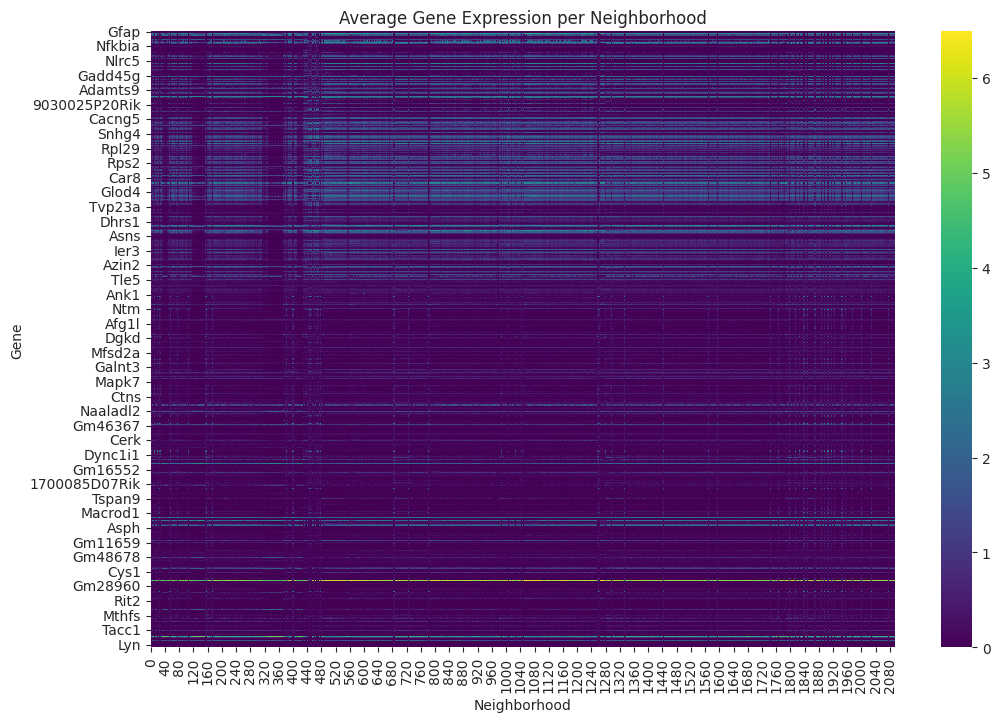

In [196]:
# Step 5: Save or Visualize the Results
# Save to CSV
# average_expression_per_nhood.to_csv('./average_expression_per_nhood.csv')

# Optionally, plot a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(average_expression_per_nhood, cmap='viridis', cbar=True)
plt.title('Average Gene Expression per Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Gene')
plt.show()

In [197]:
# Step 1: Extract the neighborhood annotations and map them to neighborhoods
nhood_annotations = mdata['milo'].var['nhood_annotation']
nhood_annotations.head

<bound method NDFrame.head of 0       NFOLs
1       NFOLs
2       NFOLs
3       NFOLs
4       MFOLs
        ...  
2089     OPCs
2090    MOL_B
2091    Mixed
2092     OPCs
2093    MOL_B
Name: nhood_annotation, Length: 2094, dtype: category
Categories (13, object): ['cycl_OPCs' < 'OPCs' < 'COPs' < 'NFOLs' ... 'MOL_E' < 'MOL_F' < 'MOL_G' < 'Mixed']>

In [198]:
# Create a mapping from neighborhood index to annotations
nhood_mapping = nhood_annotations.to_dict()
print(nhood_annotations.shape)

(2094,)


In [201]:
# Step 1: Extract the neighborhood annotations
nhood_annotations = mdata['milo'].var['nhood_annotation'].to_list()

# Step 2: Create new column names combining indices and annotations
new_column_names = [f'Neighborhood_{i}_{nhood_annotations[i]}' for i in range(len(nhood_annotations))]

# Step 3: Rename the columns in average_expression_per_nhood
average_expression_per_nhood.columns = new_column_names

# Display the updated DataFrame with new column names
print(average_expression_per_nhood.head())

           Neighborhood_0_NFOLs  Neighborhood_1_NFOLs  Neighborhood_2_NFOLs  \
gene_name                                                                     
Gfap                   0.049182              0.095521               0.06227   
S100a10                0.010415              0.012825                     0   
Cldn11                 1.956737               2.19131              1.430658   
Neat1                  1.286374               1.22817              0.854268   
Sv2c                   0.025121              0.036202              0.027227   

           Neighborhood_3_NFOLs  Neighborhood_4_MFOLs  Neighborhood_5_Mixed  \
gene_name                                                                     
Gfap                   0.038381              0.028821              0.029705   
S100a10                0.037622              0.010012              0.076109   
Cldn11                 3.040301              2.590911              2.888066   
Neat1                  1.287592              0.9612

In [202]:
desired_cell_types_order = ['cycl_OPCs', 'OPCs', 'COPs', 'NFOLs', 'MFOLs', 'MOL_A', 'MOL_B', 
                            'MOL_C', 'MOL_D', 'MOL_E', 'MOL_F', 'MOL_G', 'Mixed']


# Step 1: Subset 'average_expression_per_nhood' to keep only significant columns
# First, get the 'Sig_columns' from 'nhood_sig_sorted'
significant_columns = nhood_sig_sorted['Sig_columns'].tolist()

# Subset the 'average_expression_per_nhood' DataFrame to keep only these significant columns
subset_expression_df = average_expression_per_nhood[significant_columns]

# Step 2: Sort the columns of 'subset_expression_df' based on 'nhood_annotation'
# Map the column names to the desired cell type order
cell_type_order_mapping = {cell_type: i for i, cell_type in enumerate(desired_cell_types_order)}

# Extract the cell type from each column name (assuming it's at the end of the name after the last '_')
subset_expression_df.columns = pd.Categorical(subset_expression_df.columns, 
                                              categories=sorted(subset_expression_df.columns, 
                                                                key=lambda col: cell_type_order_mapping.get(col.split('_')[-1], float('inf'))),
                                              ordered=True)

# Sort the columns in the subset dataframe
sorted_expression_df = subset_expression_df.sort_index(axis=1)

# Step 3: Display the sorted DataFrame for plotting
print(sorted_expression_df.head())

           Neighborhood_1297_cycl_OPCs  Neighborhood_1828_cycl_OPCs  \
gene_name                                                             
Gfap                          0.168417                      0.16694   
S100a10                       0.225633                     0.154974   
Cldn11                        0.350138                      0.20408   
Neat1                         0.197771                     0.206785   
Sv2c                          0.299629                     0.283774   

           Neighborhood_2047_cycl_OPCs  Neighborhood_450_cycl_OPCs  \
gene_name                                                            
Gfap                          0.323699                    0.156479   
S100a10                       0.477762                    0.466032   
Cldn11                        0.403122                    0.615467   
Neat1                         0.270722                    0.097829   
Sv2c                          0.248855                    0.175283   

           

In [204]:
sorted_expression_df.shape

(591, 872)

In [206]:
# Step 1: Drop columns containing 'Mixed' in their names
filtered_expression_df = sorted_expression_df.loc[:, ~sorted_expression_df.columns.str.contains('Mixed')]
filtered_expression_df = filtered_expression_df.loc[:, ~filtered_expression_df.columns.str.contains('MOL_G')]

# Step 2: Display the filtered DataFrame
print(filtered_expression_df.shape)

(591, 789)


In [207]:
# Step 1: Get the list of genes from OPC_sig
ordered_genes = OPC_sig['gene'].tolist()

# Step 2: Reindex the rows of filtered_expression_df to match the order in OPC_sig
# This assumes that the row names of filtered_expression_df match the 'gene' column in OPC_sig
ordered_expression_df = filtered_expression_df.reindex(ordered_genes)

# Step 3: Display the ordered DataFrame
print(ordered_expression_df.head())

           Neighborhood_1297_cycl_OPCs  Neighborhood_1828_cycl_OPCs  \
gene_name                                                             
Gfap                          0.168417                      0.16694   
S100a10                       0.225633                     0.154974   
Cldn11                        0.350138                      0.20408   
Neat1                         0.197771                     0.206785   
Sv2c                          0.299629                     0.283774   

           Neighborhood_2047_cycl_OPCs  Neighborhood_450_cycl_OPCs  \
gene_name                                                            
Gfap                          0.323699                    0.156479   
S100a10                       0.477762                    0.466032   
Cldn11                        0.403122                    0.615467   
Neat1                         0.270722                    0.097829   
Sv2c                          0.248855                    0.175283   

           

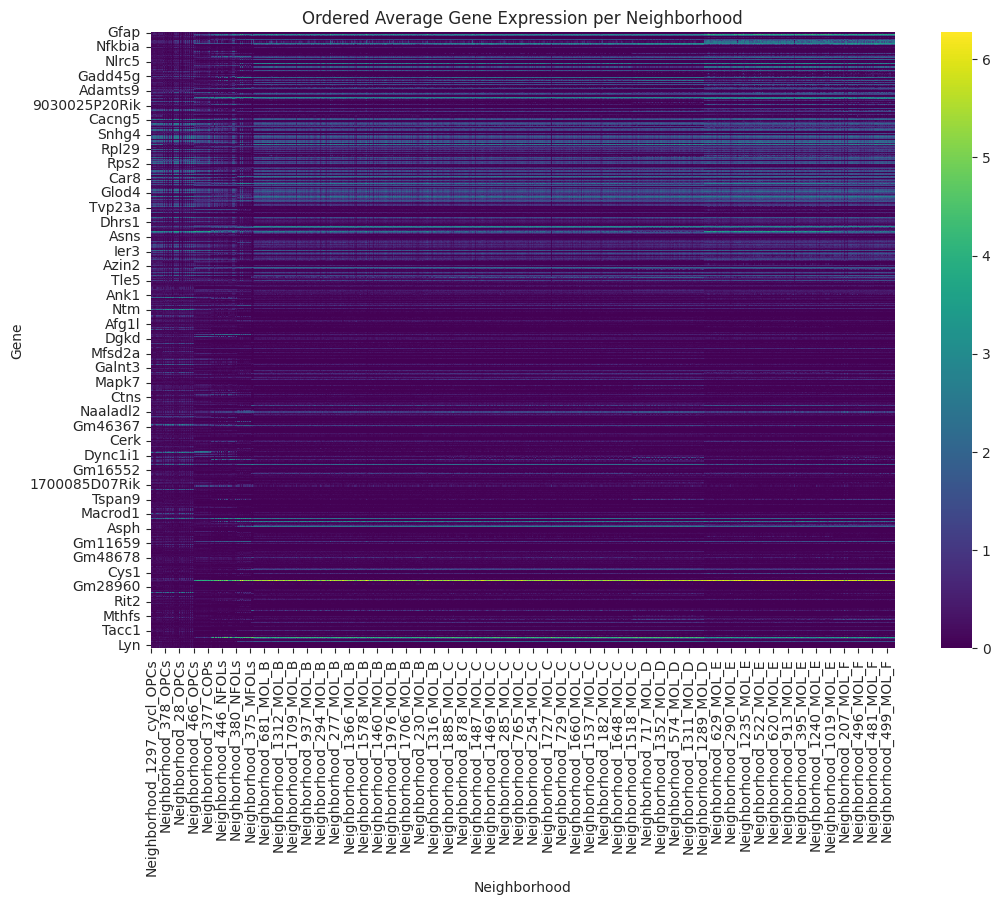

In [208]:
# Step 4: Optionally, plot the heatmap again with ordered rows
plt.figure(figsize=(12, 8))
sns.heatmap(ordered_expression_df, cmap='viridis', cbar=True)
plt.title('Ordered Average Gene Expression per Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Gene')
plt.show()

# Subset to only OPC neighborhoods?

In [209]:
# Step 1: Filter the columns to keep only those that contain 'OPC'
opc_columns = [col for col in ordered_expression_df.columns if 'OPC' in col]

# Step 2: Subset the DataFrame to keep only these columns
opc_expression_df = ordered_expression_df[opc_columns]

# Step 3: Display the subsetted DataFrame
print(opc_expression_df.head())

           Neighborhood_1297_cycl_OPCs  Neighborhood_1828_cycl_OPCs  \
gene_name                                                             
Gfap                          0.168417                      0.16694   
S100a10                       0.225633                     0.154974   
Cldn11                        0.350138                      0.20408   
Neat1                         0.197771                     0.206785   
Sv2c                          0.299629                     0.283774   

           Neighborhood_2047_cycl_OPCs  Neighborhood_450_cycl_OPCs  \
gene_name                                                            
Gfap                          0.323699                    0.156479   
S100a10                       0.477762                    0.466032   
Cldn11                        0.403122                    0.615467   
Neat1                         0.270722                    0.097829   
Sv2c                          0.248855                    0.175283   

           

In [213]:
# Step 1: Subset nhood_sig to keep only rows where 'Sig_columns' exist in the filtered expression data columns
nhood_sig_filtered = nhood_sig[nhood_sig['Sig_columns'].isin(opc_expression_df.columns)]

# Step 2: Sort the filtered DataFrame by 'logFC'
nhood_sig_sorted = nhood_sig_filtered.sort_values(by='logFC', ascending=False)

# Step 3: Display the sorted DataFrame
print(nhood_sig_sorted.head())

# Optional: check the shape and content of the filtered DataFrame
print(nhood_sig_sorted.shape)

      Sig     logFC  SpatialFDR nhood_annotation            Sig_columns  \
466  True  7.939438    0.000159             OPCs  Neighborhood_466_OPCs   
515  True  7.893403    0.000287             OPCs  Neighborhood_515_OPCs   
510  True  6.802521    0.000414             OPCs  Neighborhood_510_OPCs   
449  True  6.743794    0.000485             OPCs  Neighborhood_449_OPCs   
452  True  6.055527    0.000460             OPCs  Neighborhood_452_OPCs   

     sort_order  
466         1.0  
515         1.0  
510         1.0  
449         1.0  
452         1.0  
(46, 6)


In [217]:
# Step 3: Display the sorted DataFrame
print(nhood_sig_sorted.tail())

       Sig     logFC  SpatialFDR nhood_annotation                 Sig_columns  \
683   True  2.101579    0.061932             OPCs       Neighborhood_683_OPCs   
712   True  2.075222    0.079489             OPCs       Neighborhood_712_OPCs   
701   True  2.004644    0.054729        cycl_OPCs  Neighborhood_701_cycl_OPCs   
1382  True -2.365885    0.073021             OPCs      Neighborhood_1382_OPCs   
2049  True -2.395764    0.047799             OPCs      Neighborhood_2049_OPCs   

      sort_order  
683          1.0  
712          1.0  
701          0.0  
1382         1.0  
2049         1.0  


In [214]:
# Extract the ordered column names from nhood_sig_sorted
ordered_columns = nhood_sig_sorted['Sig_columns'].tolist()

# Ensure all columns in ordered_columns are in ordered_expression_df
# If there are any columns in ordered_columns that are not in ordered_expression_df, handle them
ordered_columns = [col for col in ordered_columns if col in ordered_expression_df.columns]

# Subset and reorder the DataFrame
reordered_expression_df = ordered_expression_df[ordered_columns]

# Display the reordered DataFrame
print(reordered_expression_df.head())

           Neighborhood_466_OPCs  Neighborhood_515_OPCs  \
gene_name                                                 
Gfap                    0.407124               0.527406   
S100a10                 0.436545               0.513496   
Cldn11                  0.542873               0.822686   
Neat1                   0.281134               0.238824   
Sv2c                    0.901659               0.742285   

           Neighborhood_510_OPCs  Neighborhood_449_OPCs  \
gene_name                                                 
Gfap                    0.279383               0.266133   
S100a10                 0.451983               0.171408   
Cldn11                  0.537441               0.250864   
Neat1                   0.174646               0.256978   
Sv2c                    0.645065               0.783958   

           Neighborhood_452_OPCs  Neighborhood_469_OPCs  \
gene_name                                                 
Gfap                    0.271151               0.23269

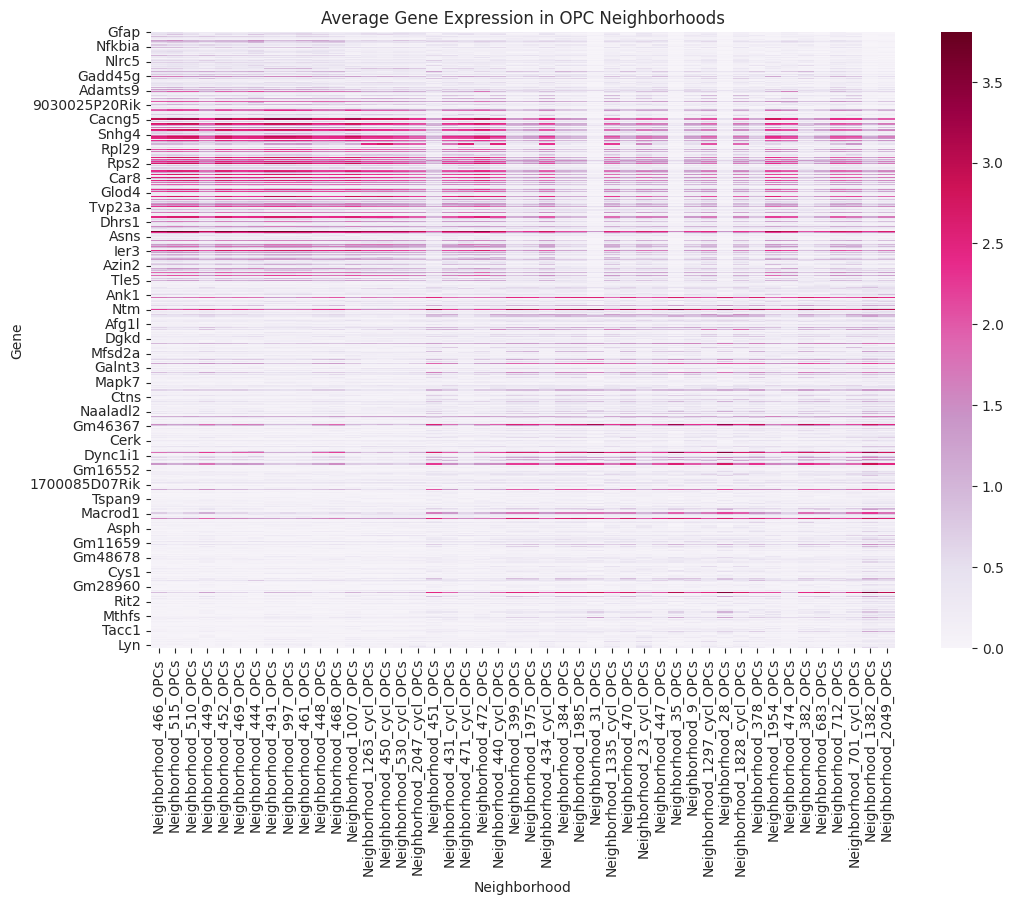

In [216]:
# Step 4: Optionally, plot the heatmap for the subsetted data
plt.figure(figsize=(12, 8))
sns.heatmap(reordered_expression_df, cmap='PuRd', cbar=True)
plt.title('Average Gene Expression in OPC Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Gene')
plt.show()